待處理的檔案: []


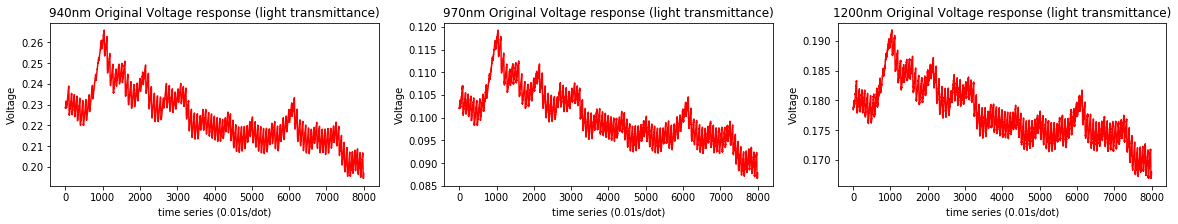

-------------------------------------------------------------------------------------------------


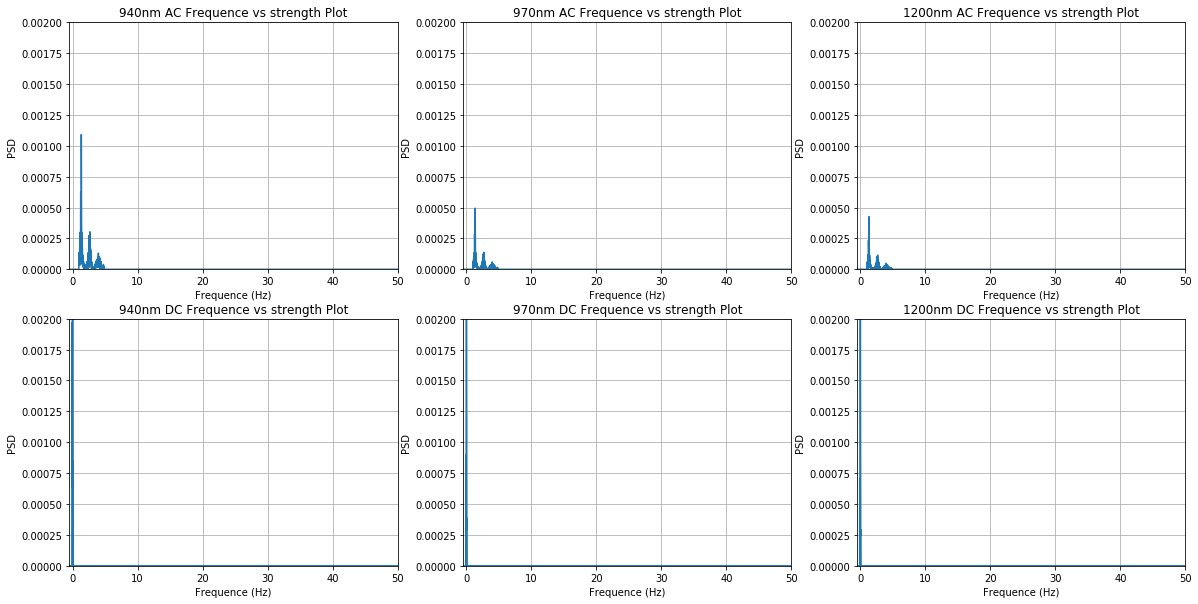

-------------------------------------------------------------------------------------------------


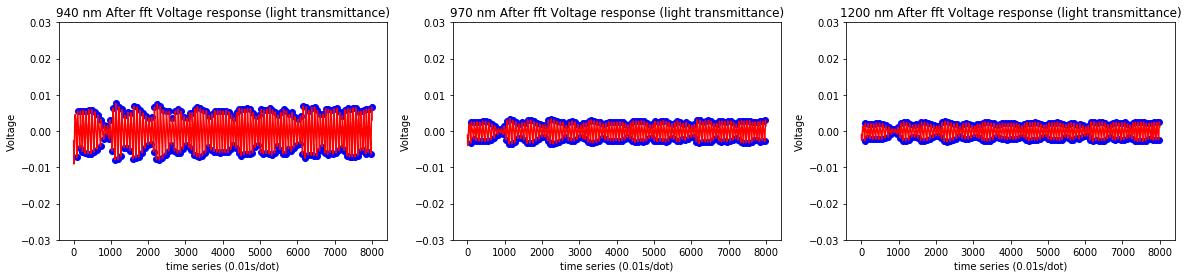

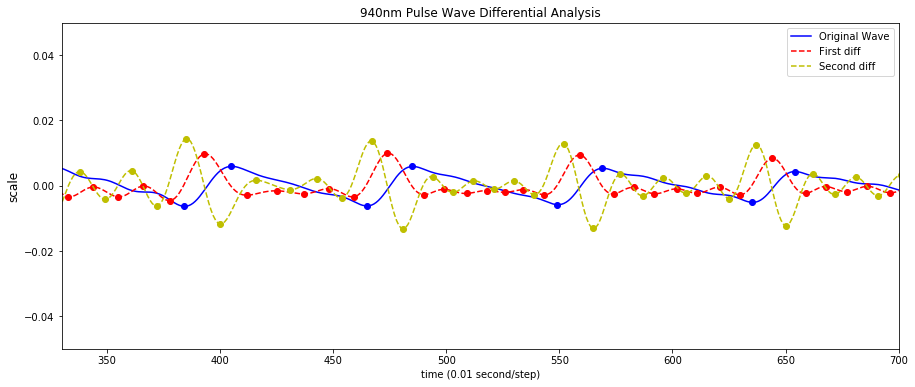

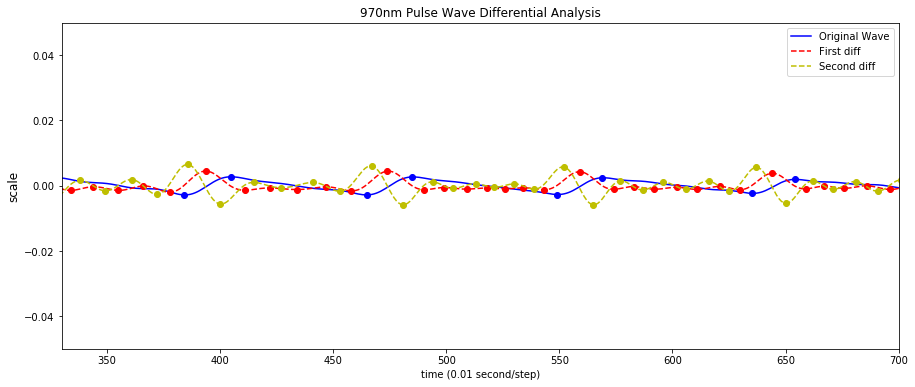

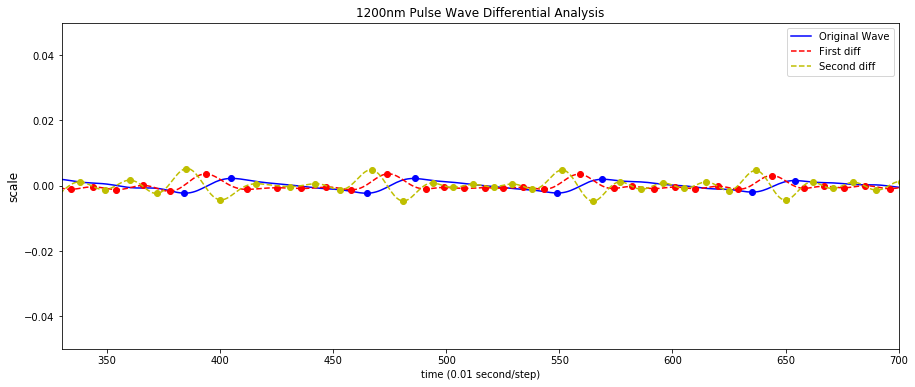

fileName: 0854-2_Volts_20181120_085550.txt 處理完成 



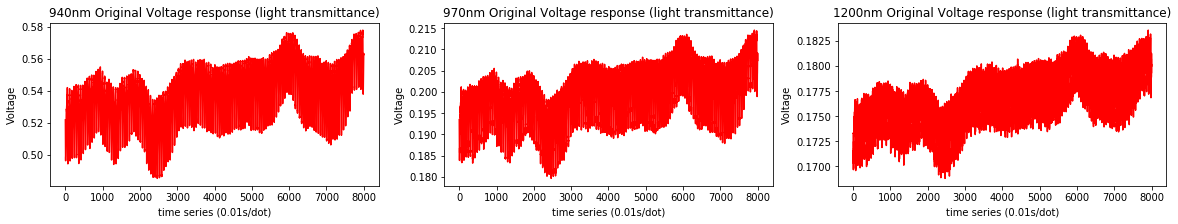

-------------------------------------------------------------------------------------------------


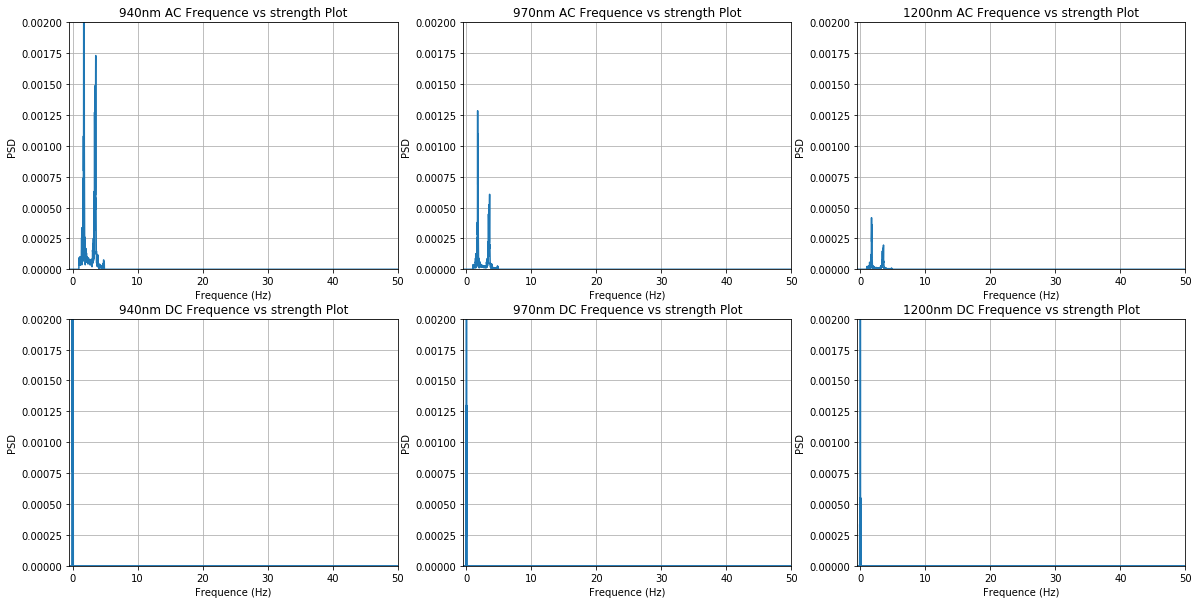

-------------------------------------------------------------------------------------------------


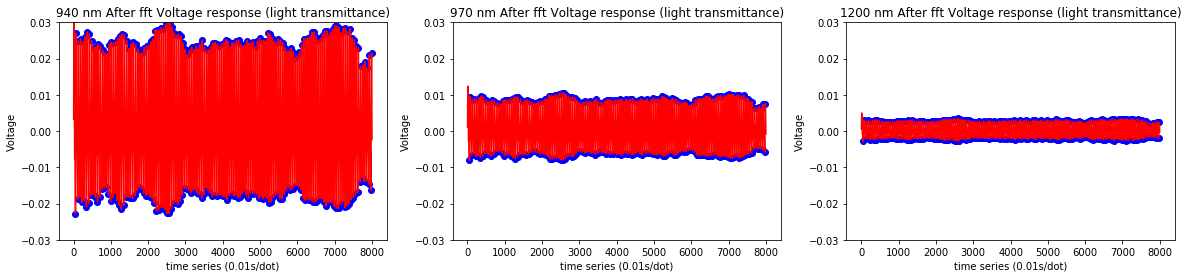

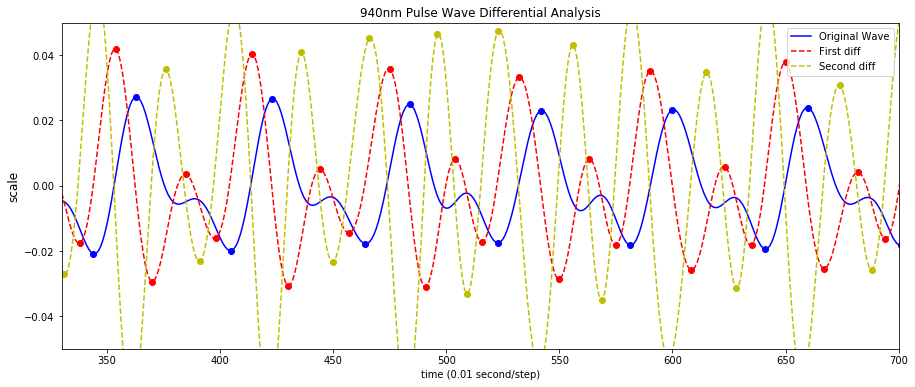

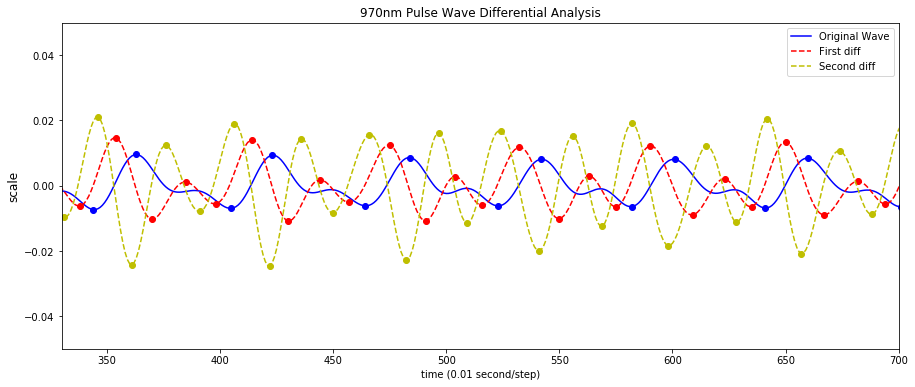

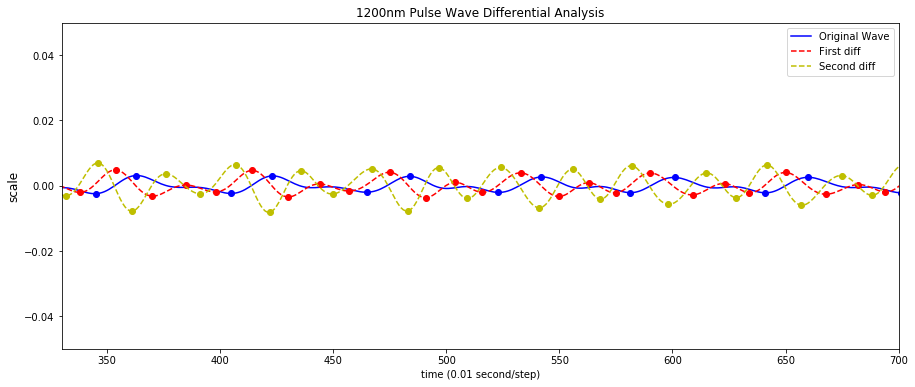

fileName: 1115-1300-1_Volts_20181123_112419.txt 處理完成 



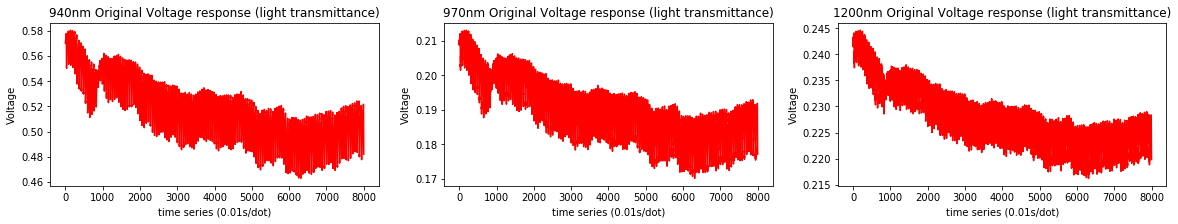

-------------------------------------------------------------------------------------------------


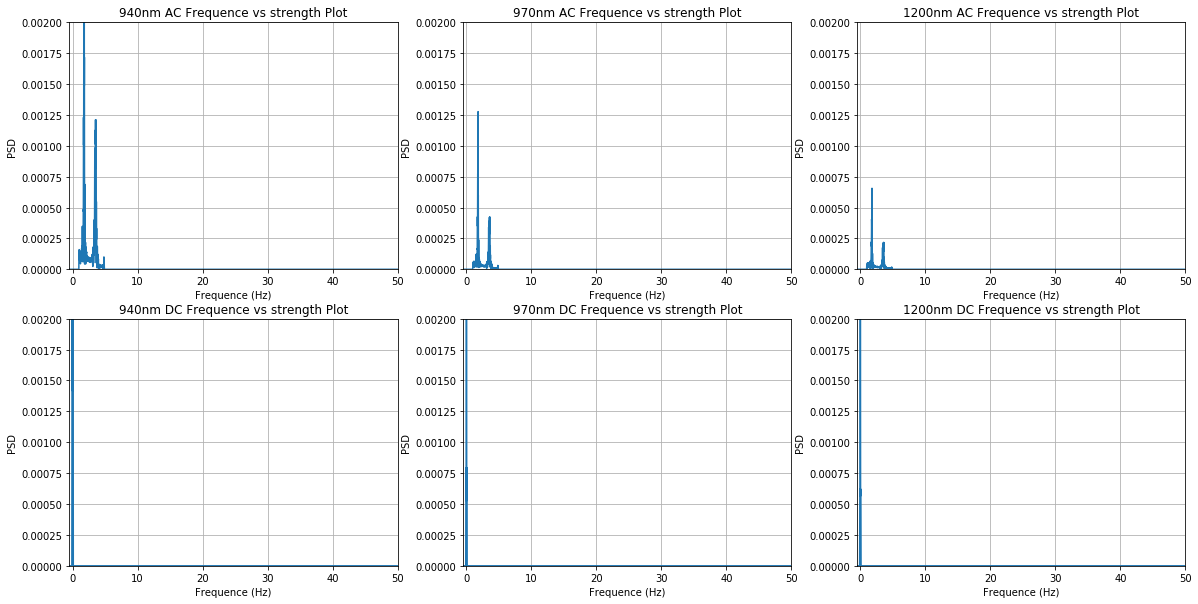

-------------------------------------------------------------------------------------------------


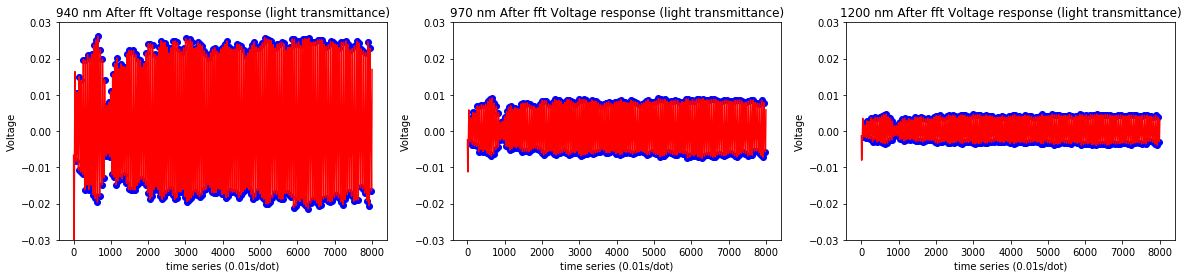

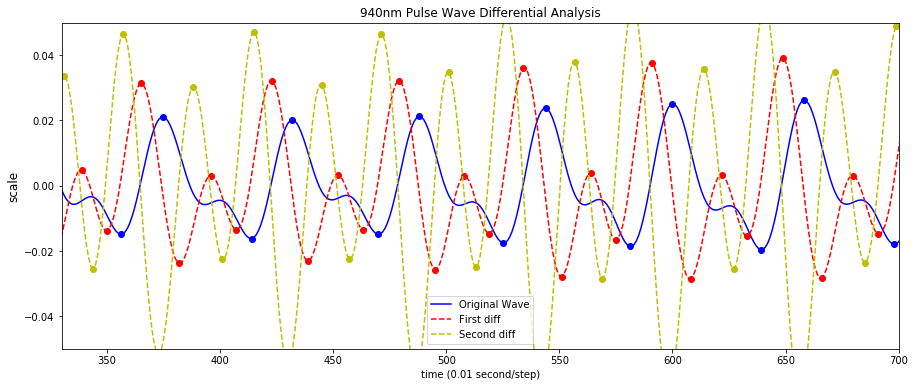

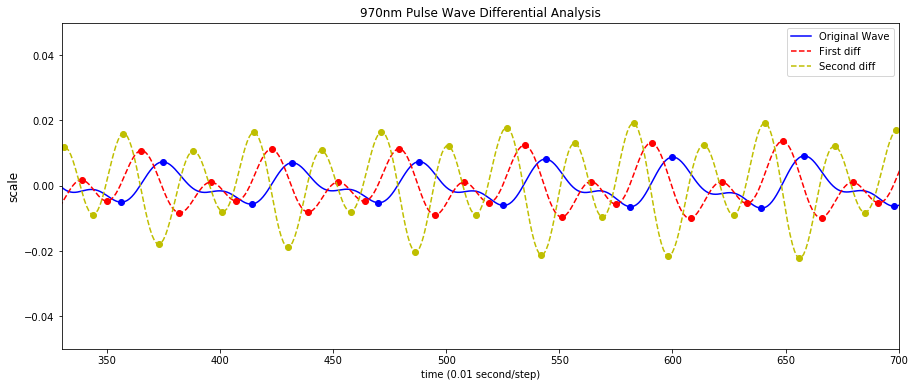

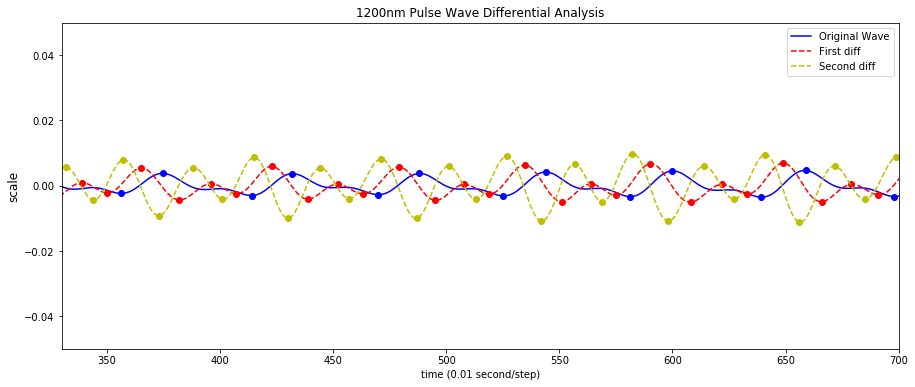

fileName: 1115-1_Volts_20181123_112051.txt 處理完成 



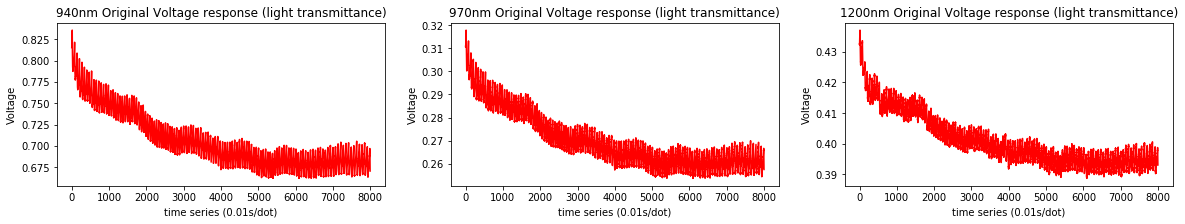

-------------------------------------------------------------------------------------------------


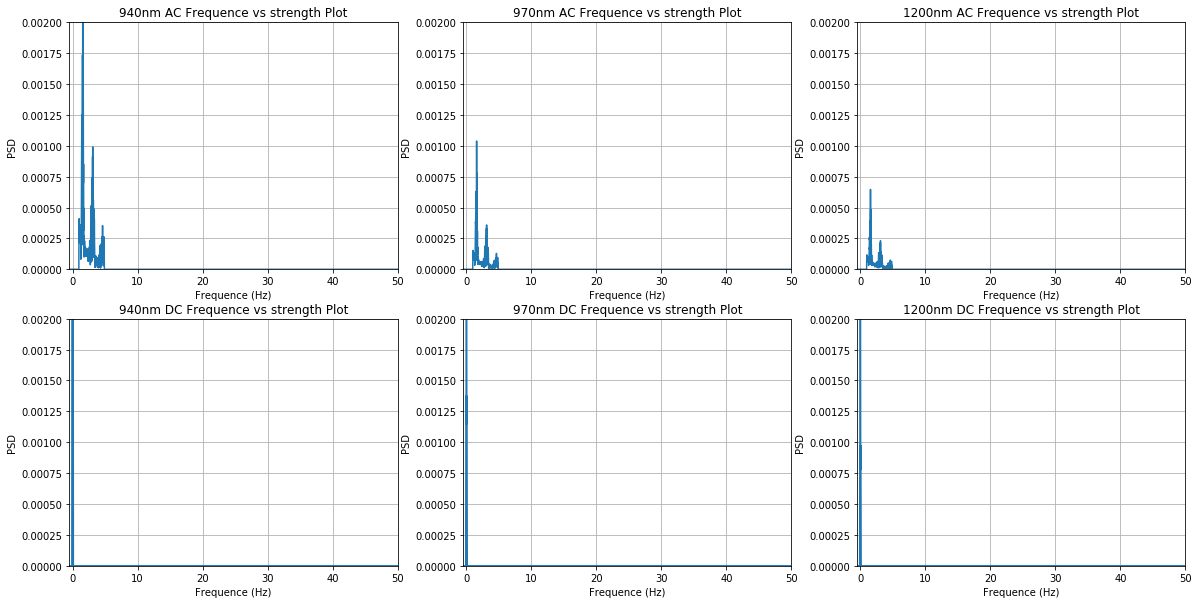

-------------------------------------------------------------------------------------------------


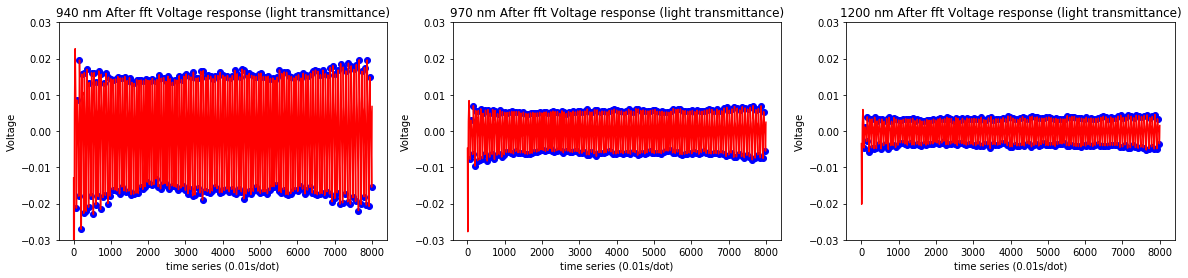

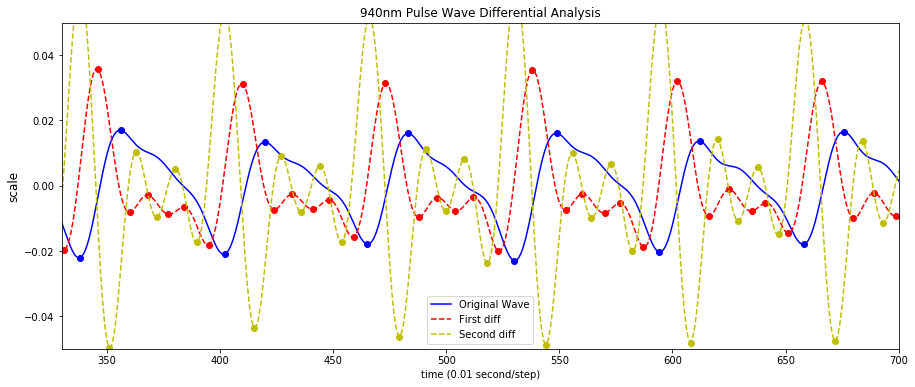

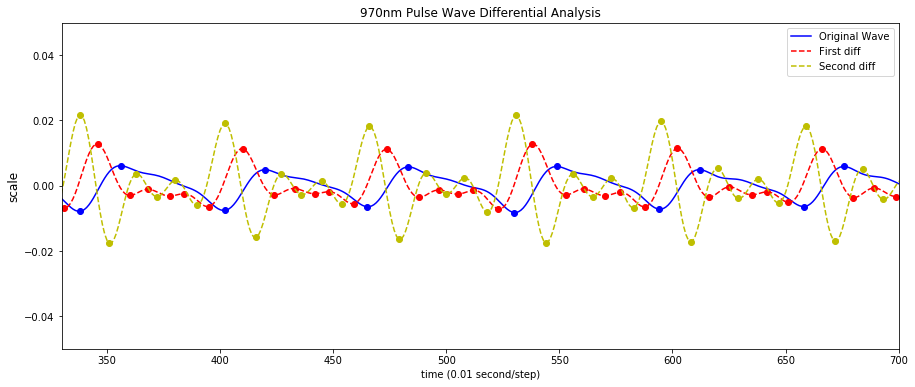

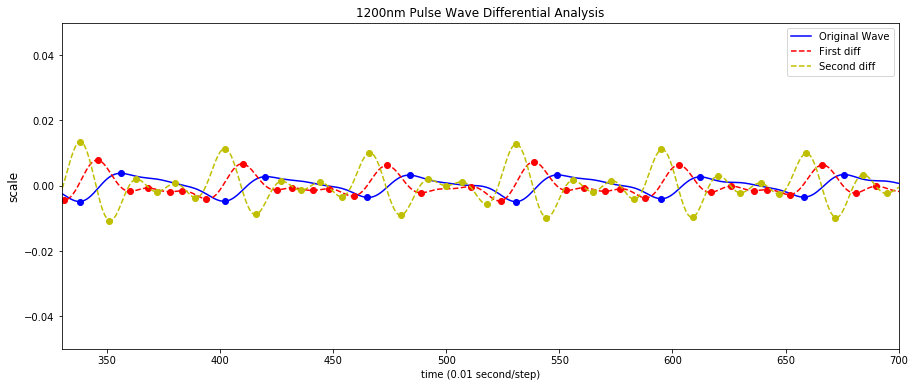

fileName: 1227-1_Volts_20181126_122932.txt 處理完成 



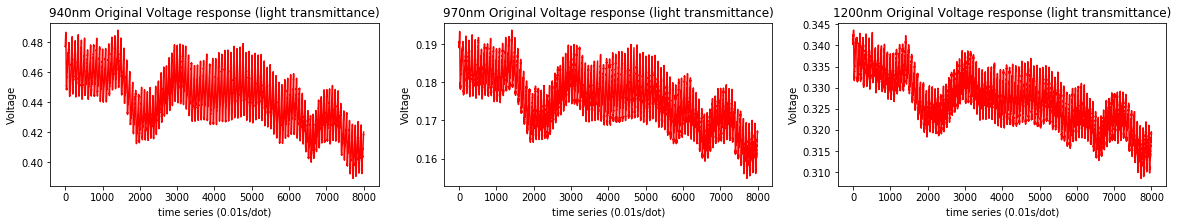

-------------------------------------------------------------------------------------------------


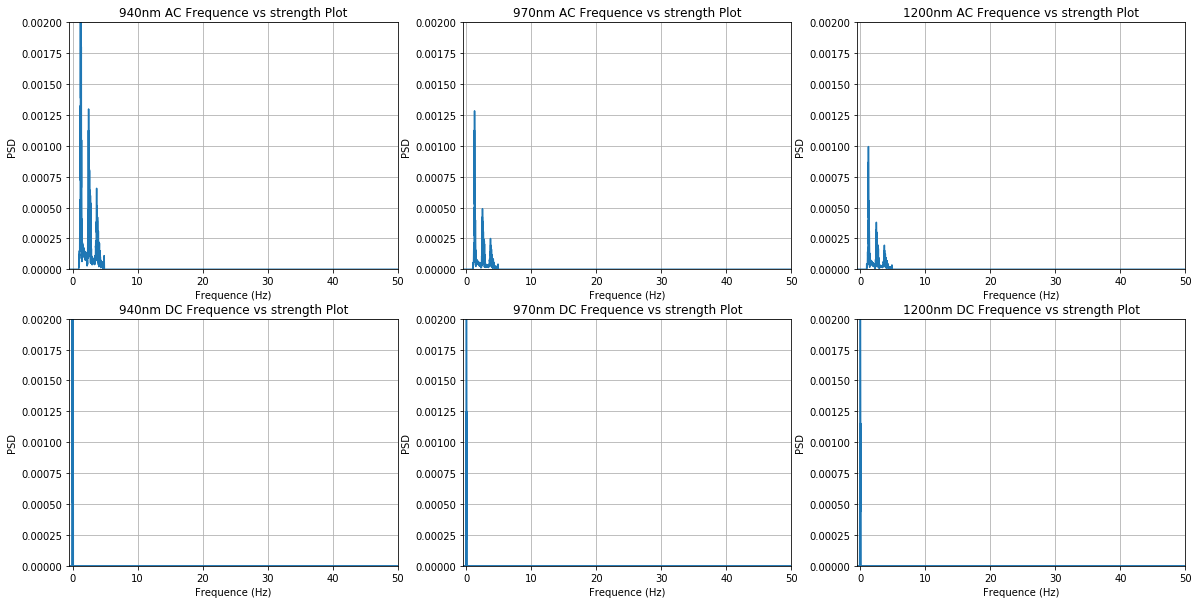

-------------------------------------------------------------------------------------------------


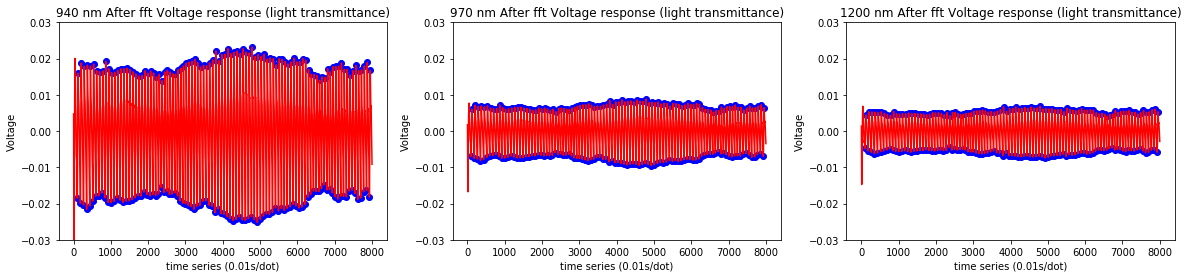

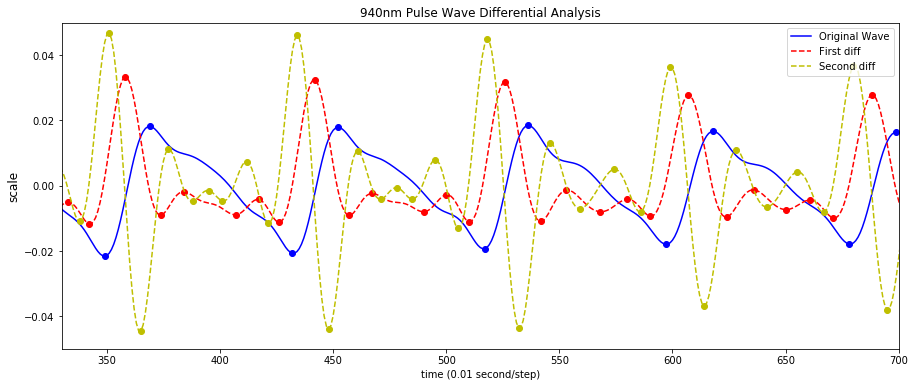

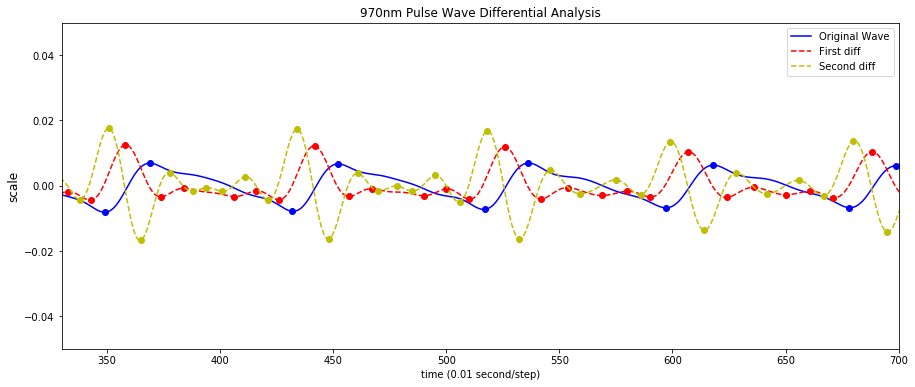

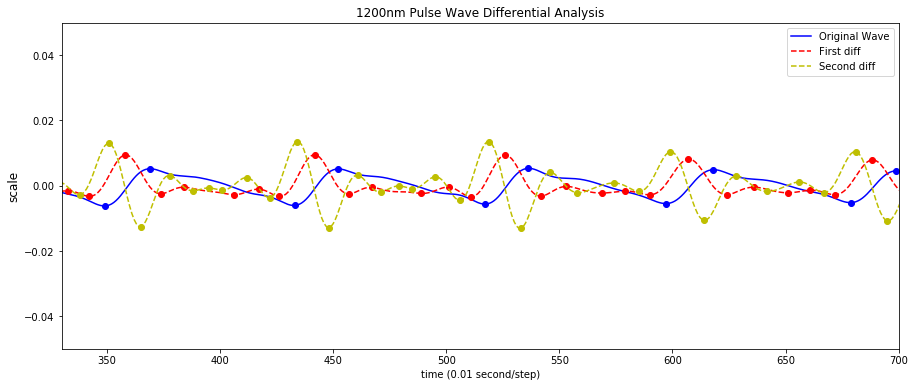

fileName: 1955-2_Volts_20181204_195658.txt 處理完成 



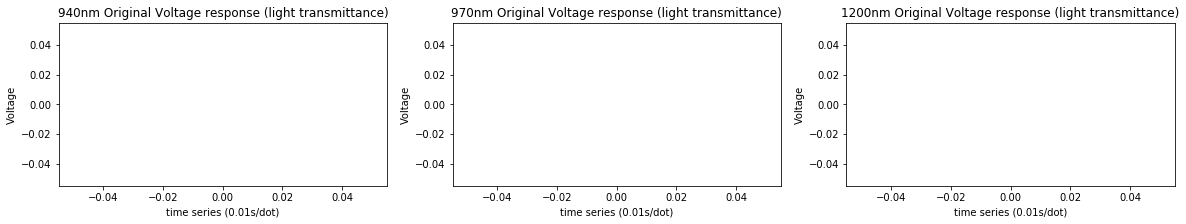

-------------------------------------------------------------------------------------------------
fileName: ffted_list_diabetes.txt 檔案內容不正確，無法處理 

總共 6 個檔案處理完成
所有檔案輸:all data summary.xlsx


In [103]:
import os
import numpy as np
from numpy.fft import fftfreq, fftshift
from scipy import linspace
import matplotlib.pyplot as plt
import peakutils
import pandas as pd
from pandas import DataFrame
from pandas import ExcelWriter
#import math
from scipy.integrate import simps

#-------------------------原始檔案的副檔名xls錯誤，所以需要重新命名txt-------------------------
#讀取所有xls file的檔案
files = [f for f in os.listdir('.') if os.path.isfile(f)]
xls_file = []
for f in files:
    if f[-3:] == 'xls':
        xls_file.append(f)   
print('待處理的檔案:',xls_file)

#將所有xls file的檔案更名為txt檔
for f in xls_file:
    base = os.path.splitext(f)[0]
    os.rename(f, base + ".txt")
#-------------------------原始檔案的副檔名xls錯誤，所以需要重新命名txt-------------------------

#-------------------------------------FFT 轉檔處理主程式-------------------------------------
def file_FFT(f):
    doc = open(f, 'r')
    lines = doc.readlines()
    newlines = []
    for line in lines:
        # 確認只要6 column 的數才要
        if len(line.split('\t')) == 6:        
        # 將 line 加到新的 newlines 中
            newlines.append(line.split())
    df = pd.DataFrame(newlines,columns = ['Ch : LED 2','Ch : LED 3','Ch : LED 1','x','xx','xxx'] )
    #只要前3 column
    df = df.iloc[:,0:3]
    #调整列顺序
    df = df[['Ch : LED 1','Ch : LED 2','Ch : LED 3']]
    #Create list for AC and DC processing
    led1_list = df['Ch : LED 1'].tolist()
    led2_list = df['Ch : LED 2'].tolist()
    led3_list = df['Ch : LED 3'].tolist()
    led1_list = [float(i) for i in led1_list]
    led2_list = [float(i) for i in led2_list]
    led3_list = [float(i) for i in led3_list]

    # -----------setting parameters for AC data collection---------------

    # set the window size for filtering out low frequencies, the bigger the size, the more low frequencies would be block out
    # N次/80second = xHz, 所以N次= 80second*xHz
    freqHz = 1
    window_size = int(80*freqHz)
    # set the winodw size for filtering out high frequencies
    freqHz1 = 5
    window_size1 = int(80*freqHz1)

    # -----------setting parameters for DC data collection---------------

    # set the window size for filtering out low frequencies, the bigger the size, the more low frequencies would be block out
    freqHz2 = 0.01
    window_size2 = int(80*freqHz2)
    # set the winodw size for filtering out high frequencies
    freqHz3 = 0.1
    window_size3 = int(80*freqHz3)
    viewing_window = 8000

    # ------------end of setteing ---------------

    # -------------------------plotting the raw data-------------------------
    def raw_data_plotting(list,x): #原始list作圖
        plt.plot(list[:viewing_window], 'r')
        plt.title(str(x)+'nm Original Voltage response (light transmittance)')
        plt.xlabel('time series (0.01s/dot)')
        plt.ylabel('Voltage')   

    plt.figure(figsize=(20,3))
    plt.subplot(131)
    raw_data_plotting(led1_list,940)
    plt.subplot(132)
    raw_data_plotting(led2_list,970)
    plt.subplot(133)
    raw_data_plotting(led3_list,1200)
    plt.show()
    print("-------------------------------------------------------------------------------------------------")
    # -------------------------plotting the raw data-------------------------
    
    # ----------------------do fft (Create name of AC and DC for processing)----------------------
    led1_fft_AC_ori = np.fft.fft(led1_list)
    led1_fft_DC_ori = np.fft.fft(led1_list)
    led2_fft_AC_ori = np.fft.fft(led2_list)
    led2_fft_DC_ori = np.fft.fft(led2_list)
    led3_fft_AC_ori = np.fft.fft(led3_list)
    led3_fft_DC_ori = np.fft.fft(led3_list)

    # --------------------------filtering Processing for data collection--------------------------
    def filtering_fuc(led_fft_AC,led_fft_DC):
        # filtering for AC data collection

        # set low frequencies to zero
        if window_size >0:
            led_fft_AC[:window_size] = 0
            led_fft_AC[-window_size:] = 0
        else:
            pass

        # set high frequencies to zero
        if window_size1 >0:
            led_fft_AC[window_size1:-window_size1] = 0
        else:
            pass

        # filtering for DC data collection

        # set low frequencies to zero
        if window_size2 >0:
            led_fft_DC[:window_size2] = 0
            led_fft_DC[-window_size2:] = 0
        else:
            pass

        # set high frequencies to zero

        if window_size3 >0:
            led_fft_DC[window_size3:-window_size3] = 0
        else:
            pass

        return led_fft_AC,led_fft_DC

    led1_fft_AC = filtering_fuc(led1_fft_AC_ori,led1_fft_DC_ori)[0]
    led1_fft_DC = filtering_fuc(led1_fft_AC_ori,led1_fft_DC_ori)[1]
    led2_fft_AC = filtering_fuc(led2_fft_AC_ori,led2_fft_DC_ori)[0]
    led2_fft_DC = filtering_fuc(led2_fft_AC_ori,led2_fft_DC_ori)[1]
    led3_fft_AC = filtering_fuc(led3_fft_AC_ori,led3_fft_DC_ori)[0]
    led3_fft_DC = filtering_fuc(led3_fft_AC_ori,led3_fft_DC_ori)[1]
    # --------------------------filtering Processing for data collection--------------------------

    # -------------------------plot the fft data-------------------------
    #進行濾波結果繪圖 
    def fft_filter_plotting(fft_list,wavelength,type='AC'): 
        # number of signal points
        N = len(fft_list)
        # sample spacing
        T = 0.01
        x = np.linspace(0.0, N*T, N)
        yf = fft_list
        ## Get Power Spectral Density
        signalPSD = np.abs(fftshift(yf))
        PSDplot = 1.0/N*signalPSD
        ## Get frequencies corresponding to signal PSD
        xf = fftfreq(N, T)
        xf = fftshift(xf)
        # Start plot
        plt.plot(xf, PSDplot)
        plt.xlim(-0.5,50) #setting x axis range
        plt.ylim(0,0.002) #setting y axis range
        plt.grid()
        plt.title(str(wavelength)+'nm '+ type + ' Frequence vs strength Plot')
        plt.xlabel('Frequence (Hz)')
        plt.ylabel('PSD')

    # Start plot
    plt.figure(figsize=(20,10))
    plt.subplot(231)
    fft_filter_plotting(led1_fft_AC,940,type='AC')
    plt.subplot(232)
    fft_filter_plotting(led2_fft_AC,970,type='AC')
    plt.subplot(233)
    fft_filter_plotting(led3_fft_AC,1200,type='AC')
    plt.subplot(234)
    fft_filter_plotting(led1_fft_DC,940,type='DC')
    plt.subplot(235)
    fft_filter_plotting(led2_fft_DC,970,type='DC')
    plt.subplot(236)
    fft_filter_plotting(led3_fft_DC,1200,type='DC')
    plt.show()
    print("-------------------------------------------------------------------------------------------------")
    # -------------------------plot the fft data-------------------------
    
    #----------------------ifft process section-------------------------
    # do ifft 將波型轉向分析
    led1_AC_ifft = np.fft.ifft(led1_fft_AC).real*-1
    led1_DC_ifft = np.fft.ifft(led1_fft_DC).real*-1
    led2_AC_ifft = np.fft.ifft(led2_fft_AC).real*-1
    led2_DC_ifft = np.fft.ifft(led2_fft_DC).real*-1
    led3_AC_ifft = np.fft.ifft(led3_fft_AC).real*-1
    led3_DC_ifft = np.fft.ifft(led3_fft_DC).real*-1
    #----------------------ifft process section-------------------------

    #----------------------Diff. process section-------------------------
    #Create first diff. list and second diff. list (PS 先將強度先加強)
    led1_first_diff_list = np.diff(led1_AC_ifft,1)*10
    led1_second_diff_list = np.diff(led1_AC_ifft,2)*100
    led2_first_diff_list = np.diff(led2_AC_ifft,1)*10
    led2_second_diff_list = np.diff(led2_AC_ifft,2)*100
    led3_first_diff_list = np.diff(led3_AC_ifft,1)*10
    led3_second_diff_list = np.diff(led3_AC_ifft,2)*100
    #----------------------Diff. process section-------------------------

    #----------------------peak process section-------------------------
    def peak_valley_index_func(list,x): #x=min_dist
        #find peak
        indexes = peakutils.indexes(np.array(list), thres=0.0001/max(np.array(list)), min_dist=x)
        #find valley
        peak_valley_indexes = []
        count = 0
        index_pre = []
        for ii in indexes:
            if count == 0:
                index_pre = ii
                count = count +1
            else:
                interval = list[index_pre:ii].tolist()
                peak_valley_indexes.append(interval.index(min(interval))+index_pre) #valley
                peak_valley_indexes.append(ii) #peak
                index_pre = ii
                count = count +1
        return peak_valley_indexes

    # 940 nm/970 nm/ 1200 nm peaks indexes
    peak_valley_indexes_940 = peak_valley_index_func(led1_AC_ifft,40)
    peak_valley_indexes_970 = peak_valley_index_func(led2_AC_ifft,40)
    peak_valley_indexes_1200 = peak_valley_index_func(led3_AC_ifft,40)
    # 940 nm/970 nm/ 1200 nm first diff. peaks indexes
    peak_valley_first_indexes_940 = peak_valley_index_func(led1_first_diff_list,10)
    peak_valley_first_indexes_970 = peak_valley_index_func(led2_first_diff_list,10)
    peak_valley_first_indexes_1200 = peak_valley_index_func(led3_first_diff_list,10)
    # 940 nm/970 nm/ 1200 nm second diff. peaks indexes
    peak_valley_second_indexes_940 = peak_valley_index_func(led1_second_diff_list,10)
    peak_valley_second_indexes_970 = peak_valley_index_func(led2_second_diff_list,10)
    peak_valley_second_indexes_1200 = peak_valley_index_func(led3_second_diff_list,10)

    # plot the processed data
    def final_ploting(ifft_list,peak_index,wavelength):
        # -------------------------plot the processed data-------------------------
        time = linspace(1,viewing_window,viewing_window)
        indexes = np.asarray(peak_index)
        plt.plot(time[indexes[indexes<viewing_window]],(ifft_list)[indexes[indexes<viewing_window]],'bo')
        plt.plot(time,ifft_list[:viewing_window], 'r')
        plt.title(str(wavelength)+' nm After fft Voltage response (light transmittance)')
        plt.xlabel('time series (0.01s/dot)')
        plt.ylabel('Voltage')
        plt.ylim(-0.03,0.03) #setting y axis range

    plt.figure(figsize=(20,4))
    plt.subplot(131)
    final_ploting(led1_AC_ifft,peak_valley_indexes_940,940)
    plt.subplot(132)
    final_ploting(led2_AC_ifft,peak_valley_indexes_970,970)
    plt.subplot(133)
    final_ploting(led3_AC_ifft,peak_valley_indexes_1200,1200)
    plt.show()

    # plot the processed data
    def diff_ploting(led_AC_ifft,led_first_diff_list,led_second_diff_list,x):
        time1 = linspace(1,len(led_AC_ifft),len(led_AC_ifft))
        time2 = linspace(1,len(led_first_diff_list),len(led_first_diff_list))
        time3 = linspace(1,len(led_second_diff_list),len(led_second_diff_list))
        plt.figure(figsize=(15,6))
        plt.title(str(x)+'nm Pulse Wave Differential Analysis')
        plt.xlabel('time (0.01 second/step)')
        plt.ylabel('scale',size=12)
        plt.plot(time1,led_AC_ifft, 'b',label='Original Wave')
        plt.plot(time1[peak_valley_index_func(led_AC_ifft,40)],led_AC_ifft[peak_valley_index_func(led_AC_ifft,40)],'bo')
        plt.plot(time2,led_first_diff_list, 'r',label='First diff',linestyle = '--')
        plt.plot(time2[peak_valley_index_func(led_first_diff_list,10)],led_first_diff_list[peak_valley_index_func(led_first_diff_list,10)],'ro')
        plt.plot(time3,led_second_diff_list, 'y',label='Second diff',linestyle = '--')
        plt.plot(time3[peak_valley_index_func(led_second_diff_list,10)],led_second_diff_list[peak_valley_index_func(led_second_diff_list,10)],'yo')
        plt.xlim(330,700) #setting y axis rang
        plt.ylim(-0.05,0.05) #setting y axis range
        plt.legend()
        plt.show()

    diff_ploting(led1_AC_ifft,led1_first_diff_list,led1_second_diff_list,940)
    diff_ploting(led2_AC_ifft,led2_first_diff_list,led2_second_diff_list,970)
    diff_ploting(led3_AC_ifft,led3_first_diff_list,led3_second_diff_list,1200)
    #----------------------peak process section-------------------------

    # -------------------------重新製作dataframe,將處理好的AC and DC and diff資料放入-------------------------
    # ifft 的波型資料寫入dataframe
    df['940 AC'] = led1_AC_ifft
    df['970 AC'] = led2_AC_ifft
    df['1200 AC'] = led3_AC_ifft
    df['940 DC'] = led1_DC_ifft
    df['970 DC'] = led2_DC_ifft
    df['1200 DC'] = led3_DC_ifft

    # ifft 的peak資料
    def peak_valley_value(indexex,list):
        peak_valley_value = []
        for ii in indexex:
            peak_valley_value.append(list[ii])
        return peak_valley_value
    peak_940nm = peak_valley_value(peak_valley_indexes_940,led1_AC_ifft)
    peak_970nm = peak_valley_value(peak_valley_indexes_970,led2_AC_ifft)
    peak_1200nm = peak_valley_value(peak_valley_indexes_1200,led3_AC_ifft)
    peak_940nm_first_diff = peak_valley_value(peak_valley_first_indexes_940,led1_first_diff_list)
    peak_970nm_first_diff = peak_valley_value(peak_valley_first_indexes_970,led2_first_diff_list)
    peak_1200nm_first_diff = peak_valley_value(peak_valley_first_indexes_1200,led3_first_diff_list)
    peak_940nm_second_diff = peak_valley_value(peak_valley_second_indexes_940,led1_second_diff_list)
    peak_970nm_second_diff = peak_valley_value(peak_valley_second_indexes_970,led2_second_diff_list)
    peak_1200nm_second_diff = peak_valley_value(peak_valley_second_indexes_1200,led3_second_diff_list)

    #創造peak dataframe
    #Original wave
    df_peak_940 = DataFrame(peak_940nm, columns = ["940 Peak"])
    df_peak_970 = DataFrame(peak_970nm, columns = ["970 Peak"])
    df_peak_1200 = DataFrame(peak_1200nm, columns = ["1200 Peak"])
    df_peak_940["940 Peak index"] = peak_valley_indexes_940
    df_peak_970["970 Peak index"] = peak_valley_indexes_970
    df_peak_1200["1200 Peak index"] = peak_valley_indexes_1200
    #First diff. wave
    df_peak_940_first_diff = DataFrame(peak_940nm_first_diff, columns = ["940 firDiff Peak"])
    df_peak_970_first_diff = DataFrame(peak_970nm_first_diff, columns = ["970 firDiff Peak"])
    df_peak_1200_first_diff = DataFrame(peak_1200nm_first_diff, columns = ["1200 firDiff Peak"])
    df_peak_940_first_diff['940 firDiff Peak index'] = peak_valley_first_indexes_940
    df_peak_970_first_diff['970 firDiff Peak index'] = peak_valley_first_indexes_970
    df_peak_1200_first_diff['1200 firDiff Peak index'] = peak_valley_first_indexes_1200
    #Second diff. wave
    df_peak_940_second_diff = DataFrame(peak_940nm_second_diff, columns = ["940 secDiff Peak"])
    df_peak_970_second_diff = DataFrame(peak_970nm_second_diff, columns = ["970 secDiff Peak"])
    df_peak_1200_second_diff = DataFrame(peak_1200nm_second_diff, columns = ["1200 secDiff Peak"])
    df_peak_940_second_diff['940 secDiff Peak index'] = peak_valley_second_indexes_940
    df_peak_970_second_diff['970 secDiff Peak index'] = peak_valley_second_indexes_970
    df_peak_1200_second_diff['1200 secDiff Peak index'] = peak_valley_second_indexes_1200
    #合併為一個
    df_peak_all = df_peak_940.join([df_peak_970,df_peak_1200,df_peak_940_first_diff,df_peak_970_first_diff,
                                   df_peak_1200_first_diff,df_peak_940_second_diff,df_peak_970_second_diff,
                                   df_peak_1200_second_diff],how='outer')
    # peak_dic = {"Peak 940nm":peak_940nm,"Peak 970nm":peak_970nm,"Peak 1200nm":peak_1200nm}
    # df2 = DataFrame(peak_dic) (無法使用因為有時候peak數目不同)

    ##創造微分數據的dataframe (包括一次及二次微分)
    def df_diff_creater(L,x):
        x = str(x)
        first_diff = np.diff(L,1) # 一次微分
        second_diff = np.diff(L,2) # 二次微分
        df_0 = DataFrame(L, columns = ['New_AC_'+x+'_list'])
        df_1 = DataFrame(first_diff, columns = ['AC_'+x+'_first_diff'])
        df_2 = DataFrame(second_diff, columns = ['AC_'+x+'_second_diff'])
        df_diff = df_0.join([df_1,df_2],how='outer')
        return df_diff

    df_diff_940 = df_diff_creater(led1_AC_ifft,940)
    df_diff_970 = df_diff_creater(led2_AC_ifft,970)
    df_diff_1200 = df_diff_creater(led3_AC_ifft,1200)
    df_diff_all = df_diff_940.join([df_diff_970,df_diff_1200],how='outer')
    # -------------------------重新製作dataframe,將處理好的AC and DC and diff資料放入-------------------------

    # ---------------------------------------運算指標計算區--------------------------------------------
    #AC振幅數據處理, 前三筆不要，取60組的振幅平均
    def AC_amp(peak):
        peak_3_remove = peak[3:]
        ac_amplitude = []
        for i in range(1, 121):
            if i%2 ==1:
                ac_amplitude.append(peak_3_remove[i-1]-peak_3_remove[i])
        return ac_amplitude

    ac_940_amp = np.mean(np.array(AC_amp(peak_940nm)))
    ac_970_amp = np.mean(np.array(AC_amp(peak_970nm)))
    ac_1200_amp = np.mean(np.array(AC_amp(peak_1200nm)))


    #AC width數據處理, 前三筆不要，取60組的"右"波峰-波谷距離平均
    def AC_width(peak_indexes):
        indexes_3_remove = peak_indexes[3:]
        ac_dist = []
        for i in range(1, 121):
            if i%2 ==1:
                ac_dist.append(indexes_3_remove[i]-indexes_3_remove[i-1])
        return ac_dist

    ac_width_940 = np.mean(np.array(AC_width(peak_valley_indexes_940)))
    ac_width_970 = np.mean(np.array(AC_width(peak_valley_indexes_970))) 
    ac_width_1200 = np.mean(np.array(AC_width(peak_valley_indexes_1200))) 


    #計算角度 DEGREES(ATAN((高)/底))
    # Degree_940 = math.degrees(math.atan(ac_940_amp*1000/ac_width_940))
    # Degree_970 = math.degrees(math.atan(ac_970_amp*1000/ac_width_970))
    # Degree_1200 = math.degrees(math.atan(ac_1200_amp*1000/ac_width_1200))

    #計算斜邊 = ((高)^2 + (底)^2)^0.5 
    # Hypotenuse_940 = pow(pow(ac_940_amp*1000,2)+pow(ac_width_940,2),0.5)
    # Hypotenuse_970 = pow(pow(ac_970_amp*1000,2)+pow(ac_width_970,2),0.5)
    # Hypotenuse_1200 = pow(pow(ac_940_amp*1000,2)+pow(ac_width_1200,2),0.5)

    #DC 數據處理，取6000筆數據的平均
    dc_940 = df.iloc[0:6000, 6].mean()
    dc_970 = df.iloc[0:6000, 7].mean()
    dc_1200 = df.iloc[0:6000, 8].mean()

    #計算心跳
    # HeatRate_940 = (len(peak_940nm)//2)/80*60
    # HeatRate_970 = (len(peak_970nm)//2)/80*60
    # HeatRate_1200 = (len(peak_1200nm)//2)/80*60
    #(60/(60組最後波谷時間-60組最初波峰時間))*60 = 每分鐘幾次 (前三筆不要)
    HeatRate_940 = (60/(peak_valley_indexes_940[124]-peak_valley_indexes_940[3]))*60*100
    HeatRate_970= (60/(peak_valley_indexes_970[124]-peak_valley_indexes_970[3]))*60*100
    HeatRate_1200 = (60/(peak_valley_indexes_1200[124]-peak_valley_indexes_1200[3]))*60*100

    #計算60組積分面積
    def AC_area(ifft_list,peak_valley_indexes):
        AC_60set = ifft_list[peak_valley_indexes[3]:peak_valley_indexes[124]]
        AC_60set_abs = np.array([abs(i) for i in AC_60set])
        AC_60set_xrange = list(range(len(AC_60set_abs)))
        AC_60set_Area = simps(AC_60set_abs,AC_60set_xrange)
        return AC_60set_Area

    AC_940_Area =AC_area(led1_AC_ifft,peak_valley_indexes_940)
    AC_970_Area =AC_area(led2_AC_ifft,peak_valley_indexes_970)
    AC_1200_Area =AC_area(led3_AC_ifft,peak_valley_indexes_1200)

    #計算PWTT (只計算60組，但是刪除第一組)
    def key_peak_index_PWTT(led_AC_ifft):
        #find original wave peak
        peak_indexes = peakutils.indexes(np.array(led_AC_ifft), thres=0.0001/max(np.array(led_AC_ifft)), min_dist=40)
        #find original wave valley
        valley_indexes_list = []
        count = 0
        index_pre = []
        for ii in peak_indexes:
            if count == 0:
                index_pre = ii
                count = count +1
            else:
                interval = led_AC_ifft[index_pre:ii].tolist()
                valley_indexes_list.append(interval.index(min(interval))+index_pre) #valley
                index_pre = ii
                count = count +1
        #先將peak index array 轉list
        peak_indexes_list = peak_indexes.tolist()
        #將波谷-波峰，一組一組zip
        zipped = zip(valley_indexes_list,peak_indexes_list[1:])
        valley_peak_zip_list = list(zipped) # 轉成list

        #find second diff peak
        second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
        second_diff_peak_index = peakutils.indexes(np.array(second_diff), thres=0.0001/max(np.array(second_diff)), min_dist=10)
        #find target peak
        target_peak_for_PWTT = []
        for k in second_diff_peak_index:
            for i,j in valley_peak_zip_list:
                if k>i and k<j:
                    target_peak_for_PWTT.append(k)
            else:
                pass
        return target_peak_for_PWTT

    target_peak_for_PWTT_940 = key_peak_index_PWTT(led1_AC_ifft)
    target_peak_for_PWTT_970 = key_peak_index_PWTT(led2_AC_ifft)
    target_peak_for_PWTT_1200 = key_peak_index_PWTT(led3_AC_ifft)

    def PWTT_fun(led_AC_ifft,key_peak_index): #Target peak to dicrotic Notch peak
        second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
        #二次微分的peak
        peak_index = peakutils.indexes(np.array(second_diff), thres=0.001/max(np.array(second_diff)), min_dist=10)
        peak_index_list = peak_index.tolist()
        #輸入key_peak_index
        new_peak_index_list = key_peak_index
        #計算PWTT(interval between peak and dicrotic Notch)
        PWTT_list=[]
        for i in new_peak_index_list:
            try:
                PWTT = peak_index_list[peak_index_list.index(i)+1]-peak_index_list[peak_index_list.index(i)]
                PWTT_list.append(PWTT)
            except:
                continue
        Ave_PWTT = np.mean(PWTT_list[1:61])*0.01 #(計算60組，但是刪除第一組) 
        return Ave_PWTT

    PWTT_mean_940 = PWTT_fun(led1_AC_ifft,target_peak_for_PWTT_940)
    PWTT_mean_970 = PWTT_fun(led2_AC_ifft,target_peak_for_PWTT_970)
    PWTT_mean_1200 = PWTT_fun(led3_AC_ifft,target_peak_for_PWTT_1200)

    #計算血流速度BVI區(#參數計算60組)
    def key_peak_index_BVI(led_AC_ifft):
        #find original wave peak
        peak_indexes = peakutils.indexes(np.array(led_AC_ifft), thres=0.0001/max(np.array(led_AC_ifft)), min_dist=40)
        #find original wave valley
        valley_indexes_list = []
        count = 0
        index_pre = []
        for ii in peak_indexes:
            if count == 0:
                index_pre = ii
                count = count +1
            else:
                interval = led_AC_ifft[index_pre:ii].tolist()
                valley_indexes_list.append(interval.index(min(interval))+index_pre) #valley
                index_pre = ii
                count = count +1
        #先將peak index array 轉list
        peak_indexes_list = peak_indexes.tolist()
        #將波谷-波峰，一組一組zip
        zipped = zip(valley_indexes_list,peak_indexes_list[1:])
        valley_peak_zip_list = list(zipped) # 轉成list

        #find first diff peak
        first_diff = np.diff(led_AC_ifft,1)*10 # 二次微分
        first_diff_peak_index = peakutils.indexes(np.array(first_diff), thres=0.0001/max(np.array(first_diff)), min_dist=10)
        #find target peak
        target_peak_for_BVI = []
        for k in first_diff_peak_index:
            for i,j in valley_peak_zip_list:
                if k>i and k<j:
                    target_peak_for_BVI.append(k)
            else:
                pass
        return target_peak_for_BVI

    target_peak_for_BVI_940 = key_peak_index_BVI(led1_AC_ifft)
    target_peak_for_BVI_970 = key_peak_index_BVI(led2_AC_ifft)
    target_peak_for_BVI_1200 = key_peak_index_BVI(led3_AC_ifft)

    def BVI_cal(led_first_diff_list,peak_valley_first_indexes,key_peak_index):
        #輸入key_peak_index
        new_index_list = key_peak_index
        #計算BVI_value (Blood volecity index a)(收縮時血流最高速度的值)
        BVI_value_mean = np.mean(led_first_diff_list[new_index_list[1:61]])#(計算60組，但是刪除第一組)

        #計算BVI_time (Blood volecity time index)(收縮時血流加速時間)
        BVI_time_list = []
        for i in new_index_list:
            try:
                BVI_time = peak_valley_first_indexes[peak_valley_first_indexes.index(i)]-peak_valley_first_indexes[peak_valley_first_indexes.index(i)-1]
                BVI_time_list.append(BVI_time)
            except:
                continue
        BVI_time_mean = np.mean(BVI_time_list[1:61])#(計算60組，但是刪除第一組)

        #計算BVI_amp (收縮時血流速和前一波的差值(振幅)
        BVI_amp_list = []
        for i in new_index_list:
            try:
                BVI_amp = led_first_diff_list[peak_valley_first_indexes[peak_valley_first_indexes.index(i)]]-led_first_diff_list[peak_valley_first_indexes[peak_valley_first_indexes.index(i)-1]]
                BVI_amp_list.append(BVI_amp) 
            except:
                continue
        BVI_amp_mean = np.mean(BVI_amp_list[1:61]) #(計算60組，但是刪除第一組)

        return BVI_value_mean, BVI_time_mean, BVI_amp_mean

    BVI_value_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[0]
    BVI_value_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[0] 
    BVI_value_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[0]
    BVI_time_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[1]
    BVI_time_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[1] 
    BVI_time_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[1]
    BVI_amp_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[2]
    BVI_amp_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[2] 
    BVI_amp_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[2]

    #計算血流速度BVA區(#參數計算60組)Blood Velocity accelerated
    def BVA_cal(led_AC_ifft,key_peak_index):
        second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
        #輸入key_peak_index
        new_peak_index_list = key_peak_index
        #計算血流速度BVA
        BVA_value_list = second_diff[new_peak_index_list]
        BVA_value_mean = np.mean(BVA_value_list[1:61])#(計算60組，但是刪除第一組)
        return BVA_value_mean

    BVA_value_940 = BVA_cal(led1_AC_ifft,target_peak_for_PWTT_940)
    BVA_value_970 = BVA_cal(led2_AC_ifft,target_peak_for_PWTT_970)
    BVA_value_1200 = BVA_cal(led3_AC_ifft,target_peak_for_PWTT_1200)   

    #Summary df_summary
    df_summary = pd.DataFrame([ac_940_amp,ac_970_amp,ac_1200_amp,
                               dc_940,dc_970,dc_1200,
                               HeatRate_940,HeatRate_970,HeatRate_1200,
                               AC_940_Area,AC_970_Area,AC_1200_Area,
                               PWTT_mean_940,PWTT_mean_970,PWTT_mean_1200,
                              BVI_value_940,BVI_value_970,BVI_value_1200,
                              BVI_time_940,BVI_time_970,BVI_time_1200,
                              BVI_amp_940,BVI_amp_970,BVI_amp_1200,
                              BVA_value_940,BVA_value_970,BVA_value_1200],
                              index = ['940 AC','970 AC','1200 AC',
                                     '940 DC','970 DC','1200 DC',
                                     '940 HR','970 HR','1200 HR',
                                     '940 Area','970 Area','1200 Area',
                                     '940 PWTT','970 PWTT','1200 PWTT',
                                     '940 BVI value','970 BVI value','1200 BVI value',
                                     '940 BVI time','970 BVI time','1200 BVI time',
                                     '940 BVI amp','970 BVI amp','1200 BVI amp',
                                     '940 BVA value','970 BVA value','1200 BVA value'
                                      ],
                              columns = [f] ) # f是檔名
    # ---------------------------------------運算指標計算區--------------------------------------------

    #Save the new result into new Excel
    writer = ExcelWriter(f+'_new'+'.xlsx')
    df.to_excel(writer,'FFT Processed',index=False)
    # df_peak_940.to_excel(writer,'940nm Peak',index=False)
    # df_peak_970.to_excel(writer,'970nm Peak',index=False)
    # df_peak_1200.to_excel(writer,'1200nm Peak',index=False)
    df_diff_all.to_excel(writer,'diff all',index=False)
    df_peak_all.to_excel(writer,'Peak all')
    df_summary.to_excel(writer,'Summary',index=True)
    writer.save()
    print ('fileName:',f,'處理完成','\n')
    
    return df_summary.T
    #-------------------------------------FFT 轉檔處理主程式-------------------------------------

#-------------------------------------所有檔案轉檔執行-------------------------------------
#創建待改的 txt list
files = [f for f in os.listdir('.') if os.path.isfile(f)]
txt_file = [f for f in files if f[-3:] == 'txt']
#批次處理每個檔案
FFT_count = 0
#創造第一行df_summary for data append
new_df_summary = pd.DataFrame(['Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result',
                           'Result','Result','Result'],
                          index = ['940 AC','970 AC','1200 AC',
                                     '940 DC','970 DC','1200 DC',
                                     '940 HR','970 HR','1200 HR',
                                     '940 Area','970 Area','1200 Area',
                                     '940 PWTT','970 PWTT','1200 PWTT',
                                     '940 BVI value','970 BVI value','1200 BVI value',
                                     '940 BVI time','970 BVI time','1200 BVI time',
                                     '940 BVI amp','970 BVI amp','1200 BVI amp',
                                     '940 BVA value','970 BVA value','1200 BVA value'
                                      ],
                          columns = ['File Name'] ).T
for f in txt_file:
    try:
        FFT_count = FFT_count+1
        new_df_summary = new_df_summary.append(file_FFT(f), ignore_index=False)
    except:
        print ('fileName:',f,'檔案內容不正確，無法處理','\n')
        continue
print ('總共',FFT_count,'個檔案處理完成')

#Save the new result into new Excel
writer = ExcelWriter('all data summary.xlsx')
new_df_summary.to_excel(writer,'all Summary',index=True)
writer.save()
print ('所有檔案輸:all data summary.xlsx')


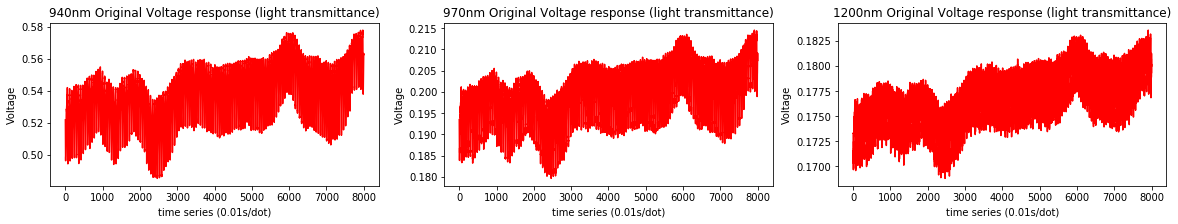

-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------


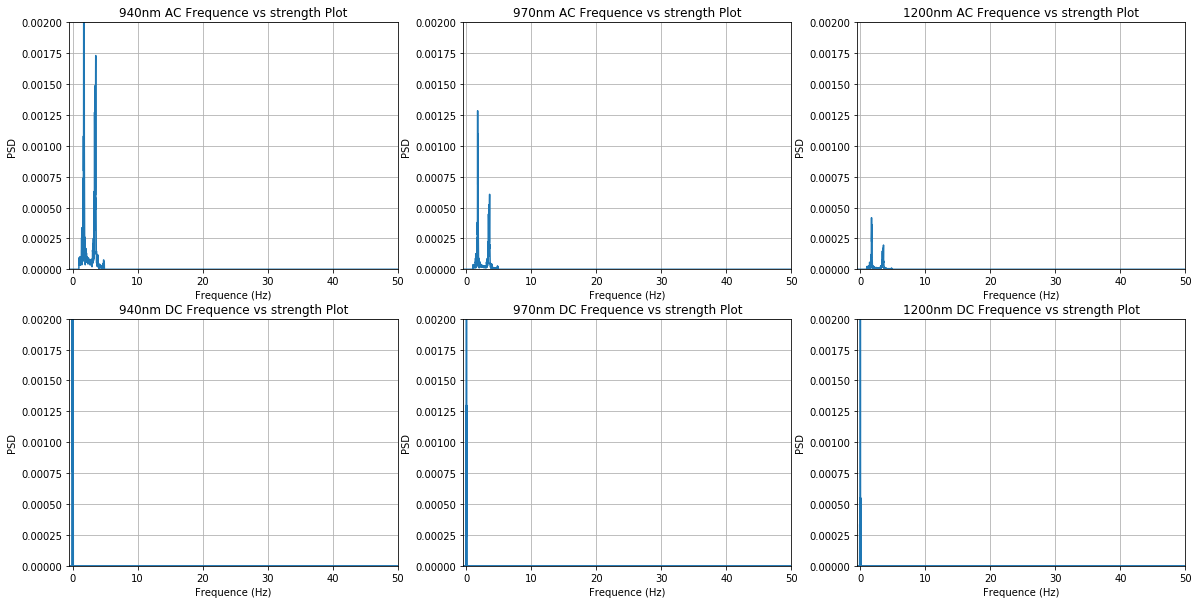

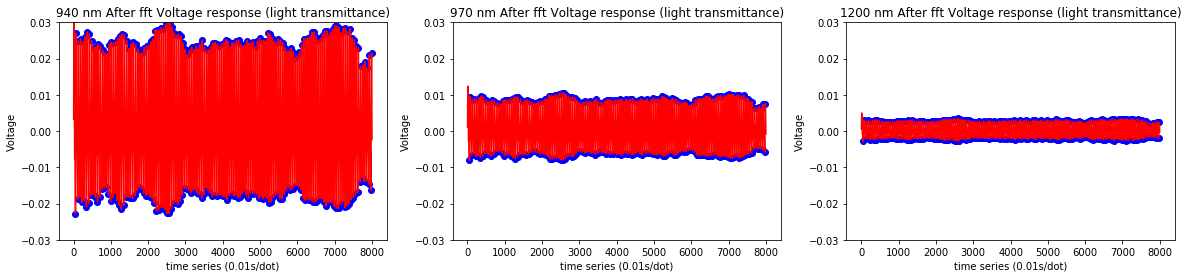

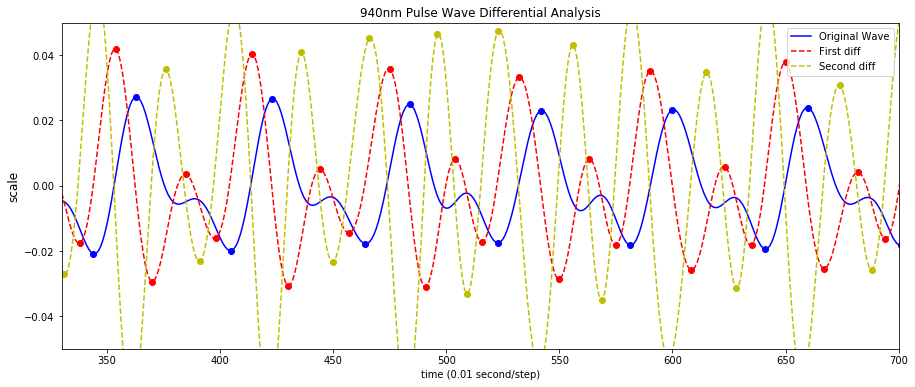

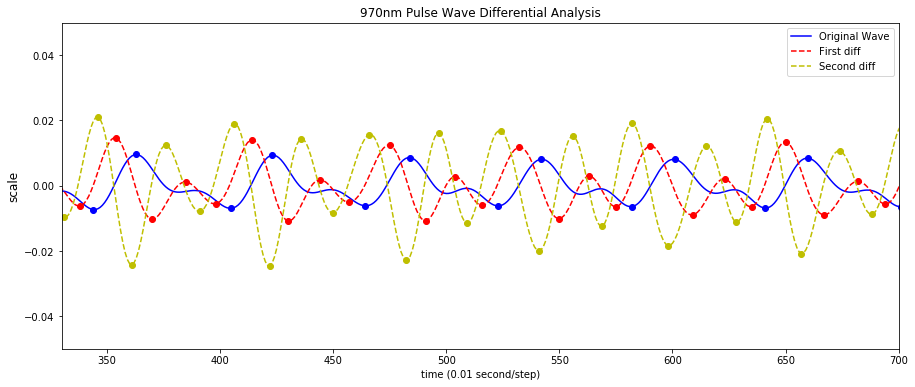

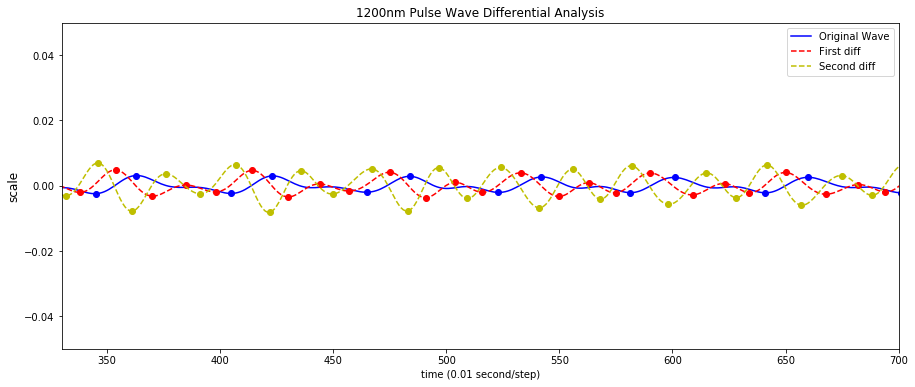

fileName: 1115-1300-1_Volts_20181123_112419.txt 處理完成 



In [102]:
#Debug use (單一檔案使用)
import os
import numpy as np
from numpy.fft import fftfreq, fftshift
from scipy import linspace
import matplotlib.pyplot as plt
import peakutils
import pandas as pd
from pandas import DataFrame
from pandas import ExcelWriter
#import math
from scipy.integrate import simps


#處理每個檔案 (需要輸入檔名)
f='1115-1300-1_Volts_20181123_112419.txt'
doc = open(f, 'r')
lines = doc.readlines()
newlines = []
for line in lines:
    # 確認只要6 column 的數才要
    if len(line.split('\t')) == 6:        
    # 將 line 加到新的 newlines 中
        newlines.append(line.split())
df = pd.DataFrame(newlines,columns = ['Ch : LED 2','Ch : LED 3','Ch : LED 1','x','xx','xxx'] )
#只要前3 column
df = df.iloc[:,0:3]
#调整列顺序
df = df[['Ch : LED 1','Ch : LED 2','Ch : LED 3']]
#Create list for AC and DC processing
led1_list = df['Ch : LED 1'].tolist()
led2_list = df['Ch : LED 2'].tolist()
led3_list = df['Ch : LED 3'].tolist()
led1_list = [float(i) for i in led1_list]
led2_list = [float(i) for i in led2_list]
led3_list = [float(i) for i in led3_list]

# -----------setting parameters for AC data collection---------------

# set the window size for filtering out low frequencies, the bigger the size, the more low frequencies would be block out
# N次/80second = xHz, 所以N次= 80second*xHz
freqHz = 1
window_size = int(80*freqHz)
# set the winodw size for filtering out high frequencies
freqHz1 = 5
window_size1 = int(80*freqHz1)

# -----------setting parameters for DC data collection---------------

# set the window size for filtering out low frequencies, the bigger the size, the more low frequencies would be block out
freqHz2 = 0.01
window_size2 = int(80*freqHz2)
# set the winodw size for filtering out high frequencies
freqHz3 = 0.1
window_size3 = int(80*freqHz3)
viewing_window = 8000

# ------------end of setteing ---------------

#-----------------------------------------plotting the raw data-----------------------------------------------
def raw_data_plotting(list,x): #原始list作圖
    plt.plot(list[:viewing_window], 'r')
    plt.title(str(x)+'nm Original Voltage response (light transmittance)')
    plt.xlabel('time series (0.01s/dot)')
    plt.ylabel('Voltage')   

plt.figure(figsize=(20,3))
plt.subplot(131)
raw_data_plotting(led1_list,940)
plt.subplot(132)
raw_data_plotting(led2_list,970)
plt.subplot(133)
raw_data_plotting(led3_list,1200)
plt.show()
print("-------------------------------------------------------------------------------------------------")
#-----------------------------------------plotting the raw data-----------------------------------------------

# ----------------------------do fft (Create name of AC and DC for processing)----------------------------
led1_fft_AC_ori = np.fft.fft(led1_list)
led1_fft_DC_ori = np.fft.fft(led1_list)
led2_fft_AC_ori = np.fft.fft(led2_list)
led2_fft_DC_ori = np.fft.fft(led2_list)
led3_fft_AC_ori = np.fft.fft(led3_list)
led3_fft_DC_ori = np.fft.fft(led3_list)

# --------------------------------filtering Processing for data collection----------------------------------

def filtering_fuc(led_fft_AC,led_fft_DC):
    # -----------filtering Processing for AC data collection---------------
    
    # set low frequencies to zero
    if window_size >0:
        led_fft_AC[:window_size] = 0
        led_fft_AC[-window_size:] = 0
    else:
        pass
    
    # set high frequencies to zero
    if window_size1 >0:
        led_fft_AC[window_size1:-window_size1] = 0
    else:
        pass
    
    # -----------filtering Processing for DC data collection---------------
    
    # set low frequencies to zero
    if window_size2 >0:
        led_fft_DC[:window_size2] = 0
        led_fft_DC[-window_size2:] = 0
    else:
        pass
    
    # set high frequencies to zero

    if window_size3 >0:
        led_fft_DC[window_size3:-window_size3] = 0
    else:
        pass
    
    return led_fft_AC,led_fft_DC

led1_fft_AC = filtering_fuc(led1_fft_AC_ori,led1_fft_DC_ori)[0]
led1_fft_DC = filtering_fuc(led1_fft_AC_ori,led1_fft_DC_ori)[1]
led2_fft_AC = filtering_fuc(led2_fft_AC_ori,led2_fft_DC_ori)[0]
led2_fft_DC = filtering_fuc(led2_fft_AC_ori,led2_fft_DC_ori)[1]
led3_fft_AC = filtering_fuc(led3_fft_AC_ori,led3_fft_DC_ori)[0]
led3_fft_DC = filtering_fuc(led3_fft_AC_ori,led3_fft_DC_ori)[1]

# -------------------------plot the fft data-------------------------
    #進行濾波結果繪圖 
def fft_filter_plotting(fft_list,wavelength,type='AC'): 
    # number of signal points
    N = len(fft_list)
    # sample spacing
    T = 0.01
    x = np.linspace(0.0, N*T, N)
    yf = fft_list
    ## Get Power Spectral Density
    signalPSD = np.abs(fftshift(yf))
    PSDplot = 1.0/N*signalPSD
    ## Get frequencies corresponding to signal PSD
    xf = fftfreq(N, T)
    xf = fftshift(xf)
    # Start plot
    plt.plot(xf, PSDplot)
    plt.xlim(-0.5,50) #setting x axis range
    plt.ylim(0,0.002) #setting y axis range
    plt.grid()
    plt.title(str(wavelength)+'nm '+ type + ' Frequence vs strength Plot')
    plt.xlabel('Frequence (Hz)')
    plt.ylabel('PSD')

# Start plot
plt.figure(figsize=(20,10))
plt.subplot(231)
fft_filter_plotting(led1_fft_AC,940,type='AC')
plt.subplot(232)
fft_filter_plotting(led2_fft_AC,970,type='AC')
plt.subplot(233)
fft_filter_plotting(led3_fft_AC,1200,type='AC')
plt.subplot(234)
fft_filter_plotting(led1_fft_DC,940,type='DC')
plt.subplot(235)
fft_filter_plotting(led2_fft_DC,970,type='DC')
plt.subplot(236)
fft_filter_plotting(led3_fft_DC,1200,type='DC')
print("-------------------------------------------------------------------------------------------------")
#------------------------plot the fft data-------------------------
    
#----------------------ifft process section-------------------------
# do ifft 將波型轉向分析
led1_AC_ifft = np.fft.ifft(led1_fft_AC).real*-1
led1_DC_ifft = np.fft.ifft(led1_fft_DC).real*-1
led2_AC_ifft = np.fft.ifft(led2_fft_AC).real*-1
led2_DC_ifft = np.fft.ifft(led2_fft_DC).real*-1
led3_AC_ifft = np.fft.ifft(led3_fft_AC).real*-1
led3_DC_ifft = np.fft.ifft(led3_fft_DC).real*-1
#----------------------ifft process section-------------------------

#----------------------Diff. process section-------------------------
#Create first diff. list and second diff. list (PS 先將強度先加強)
led1_first_diff_list = np.diff(led1_AC_ifft,1)*10
led1_second_diff_list = np.diff(led1_AC_ifft,2)*100
led2_first_diff_list = np.diff(led2_AC_ifft,1)*10
led2_second_diff_list = np.diff(led2_AC_ifft,2)*100
led3_first_diff_list = np.diff(led3_AC_ifft,1)*10
led3_second_diff_list = np.diff(led3_AC_ifft,2)*100
#----------------------Diff. process section-------------------------

#----------------------peak process section-------------------------
def peak_valley_index_func(list,x): #x=min_dist
    #find peak
    indexes = peakutils.indexes(np.array(list), thres=0.0001/max(np.array(list)), min_dist=x)
    #find valley
    peak_valley_indexes = []
    count = 0
    index_pre = []
    for ii in indexes:
        if count == 0:
            index_pre = ii
            count = count +1
        else:
            interval = list[index_pre:ii].tolist()
            peak_valley_indexes.append(interval.index(min(interval))+index_pre) #valley
            peak_valley_indexes.append(ii) #peak
            index_pre = ii
            count = count +1
    return peak_valley_indexes

# 940 nm/970 nm/ 1200 nm peaks indexes
peak_valley_indexes_940 = peak_valley_index_func(led1_AC_ifft,40)
peak_valley_indexes_970 = peak_valley_index_func(led2_AC_ifft,40)
peak_valley_indexes_1200 = peak_valley_index_func(led3_AC_ifft,40)
# 940 nm/970 nm/ 1200 nm first diff. peaks indexes
peak_valley_first_indexes_940 = peak_valley_index_func(led1_first_diff_list,10)
peak_valley_first_indexes_970 = peak_valley_index_func(led2_first_diff_list,10)
peak_valley_first_indexes_1200 = peak_valley_index_func(led3_first_diff_list,10)
# 940 nm/970 nm/ 1200 nm second diff. peaks indexes
peak_valley_second_indexes_940 = peak_valley_index_func(led1_second_diff_list,10)
peak_valley_second_indexes_970 = peak_valley_index_func(led2_second_diff_list,10)
peak_valley_second_indexes_1200 = peak_valley_index_func(led3_second_diff_list,10)

# plot the processed data
def final_ploting(ifft_list,peak_index,wavelength):
    # -------------------------plot the processed data-------------------------
    time = linspace(1,viewing_window,viewing_window)
    indexes = np.asarray(peak_index)
    plt.plot(time[indexes[indexes<viewing_window]],(ifft_list)[indexes[indexes<viewing_window]],'bo')
    plt.plot(time,ifft_list[:viewing_window], 'r')
    plt.title(str(wavelength)+' nm After fft Voltage response (light transmittance)')
    plt.xlabel('time series (0.01s/dot)')
    plt.ylabel('Voltage')
    plt.ylim(-0.03,0.03) #setting y axis range
    
plt.figure(figsize=(20,4))
plt.subplot(131)
final_ploting(led1_AC_ifft,peak_valley_indexes_940,940)
plt.subplot(132)
final_ploting(led2_AC_ifft,peak_valley_indexes_970,970)
plt.subplot(133)
final_ploting(led3_AC_ifft,peak_valley_indexes_1200,1200)
plt.show()

# plot the processed data
def diff_ploting(led_AC_ifft,led_first_diff_list,led_second_diff_list,x):
    time1 = linspace(1,len(led_AC_ifft),len(led_AC_ifft))
    time2 = linspace(1,len(led_first_diff_list),len(led_first_diff_list))
    time3 = linspace(1,len(led_second_diff_list),len(led_second_diff_list))
    plt.figure(figsize=(15,6))
    plt.title(str(x)+'nm Pulse Wave Differential Analysis')
    plt.xlabel('time (0.01 second/step)')
    plt.ylabel('scale',size=12)
    plt.plot(time1,led_AC_ifft, 'b',label='Original Wave')
    plt.plot(time1[peak_valley_index_func(led_AC_ifft,40)],led_AC_ifft[peak_valley_index_func(led_AC_ifft,40)],'bo')
    plt.plot(time2,led_first_diff_list, 'r',label='First diff',linestyle = '--')
    plt.plot(time2[peak_valley_index_func(led_first_diff_list,10)],led_first_diff_list[peak_valley_index_func(led_first_diff_list,10)],'ro')
    plt.plot(time3,led_second_diff_list, 'y',label='Second diff',linestyle = '--')
    plt.plot(time3[peak_valley_index_func(led_second_diff_list,10)],led_second_diff_list[peak_valley_index_func(led_second_diff_list,10)],'yo')
    plt.xlim(330,700) #setting y axis rang
    plt.ylim(-0.05,0.05) #setting y axis range
    plt.legend()
    plt.show()
    
diff_ploting(led1_AC_ifft,led1_first_diff_list,led1_second_diff_list,940)
diff_ploting(led2_AC_ifft,led2_first_diff_list,led2_second_diff_list,970)
diff_ploting(led3_AC_ifft,led3_first_diff_list,led3_second_diff_list,1200)
#----------------------peak process section-------------------------

# -------------------------重新製作dataframe,將處理好的AC and DC and diff資料放入-------------------------
# ifft 的波型資料寫入dataframe
df['940 AC'] = led1_AC_ifft
df['970 AC'] = led2_AC_ifft
df['1200 AC'] = led3_AC_ifft
df['940 DC'] = led1_DC_ifft
df['970 DC'] = led2_DC_ifft
df['1200 DC'] = led3_DC_ifft

# ifft 的peak資料
def peak_valley_value(indexex,led_AC_ifft):
    peak_valley_value = []
    for ii in indexex:
        peak_valley_value.append(led_AC_ifft[ii])
    return peak_valley_value
peak_940nm = peak_valley_value(peak_valley_indexes_940,led1_AC_ifft)
peak_970nm = peak_valley_value(peak_valley_indexes_970,led2_AC_ifft)
peak_1200nm = peak_valley_value(peak_valley_indexes_1200,led3_AC_ifft)
peak_940nm_first_diff = peak_valley_value(peak_valley_first_indexes_940,led1_first_diff_list)
peak_970nm_first_diff = peak_valley_value(peak_valley_first_indexes_970,led2_first_diff_list)
peak_1200nm_first_diff = peak_valley_value(peak_valley_first_indexes_1200,led3_first_diff_list)
peak_940nm_second_diff = peak_valley_value(peak_valley_second_indexes_940,led1_second_diff_list)
peak_970nm_second_diff = peak_valley_value(peak_valley_second_indexes_970,led2_second_diff_list)
peak_1200nm_second_diff = peak_valley_value(peak_valley_second_indexes_1200,led3_second_diff_list)

#創造peak dataframe
#Original wave
df_peak_940 = DataFrame(peak_940nm, columns = ["940 Peak"])
df_peak_970 = DataFrame(peak_970nm, columns = ["970 Peak"])
df_peak_1200 = DataFrame(peak_1200nm, columns = ["1200 Peak"])
df_peak_940["940 Peak index"] = peak_valley_indexes_940
df_peak_970["970 Peak index"] = peak_valley_indexes_970
df_peak_1200["1200 Peak index"] = peak_valley_indexes_1200
#First diff. wave
df_peak_940_first_diff = DataFrame(peak_940nm_first_diff, columns = ["940 firDiff Peak"])
df_peak_970_first_diff = DataFrame(peak_970nm_first_diff, columns = ["970 firDiff Peak"])
df_peak_1200_first_diff = DataFrame(peak_1200nm_first_diff, columns = ["1200 firDiff Peak"])
df_peak_940_first_diff['940 firDiff Peak index'] = peak_valley_first_indexes_940
df_peak_970_first_diff['970 firDiff Peak index'] = peak_valley_first_indexes_970
df_peak_1200_first_diff['1200 firDiff Peak index'] = peak_valley_first_indexes_1200
#Second diff. wave
df_peak_940_second_diff = DataFrame(peak_940nm_second_diff, columns = ["940 secDiff Peak"])
df_peak_970_second_diff = DataFrame(peak_970nm_second_diff, columns = ["970 secDiff Peak"])
df_peak_1200_second_diff = DataFrame(peak_1200nm_second_diff, columns = ["1200 secDiff Peak"])
df_peak_940_second_diff['940 secDiff Peak index'] = peak_valley_second_indexes_940
df_peak_970_second_diff['970 secDiff Peak index'] = peak_valley_second_indexes_970
df_peak_1200_second_diff['1200 secDiff Peak index'] = peak_valley_second_indexes_1200
#合併為一個
df_peak_all = df_peak_940.join([df_peak_970,df_peak_1200,df_peak_940_first_diff,df_peak_970_first_diff,
                               df_peak_1200_first_diff,df_peak_940_second_diff,df_peak_970_second_diff,
                               df_peak_1200_second_diff],how='outer')
# peak_dic = {"Peak 940nm":peak_940nm,"Peak 970nm":peak_970nm,"Peak 1200nm":peak_1200nm}
# df2 = DataFrame(peak_dic) (無法使用因為有時候peak數目不同)

##創造微分數據的dataframe (包括一次及二次微分)
def df_diff_creater(L,x):
    x = str(x)
    first_diff = np.diff(L,1) # 一次微分
    second_diff = np.diff(L,2) # 二次微分
    df_0 = DataFrame(L, columns = ['New_AC_'+x+'_list'])
    df_1 = DataFrame(first_diff, columns = ['AC_'+x+'_first_diff'])
    df_2 = DataFrame(second_diff, columns = ['AC_'+x+'_second_diff'])
    df_diff = df_0.join([df_1,df_2],how='outer')
    return df_diff

df_diff_940 = df_diff_creater(led1_AC_ifft,940)
df_diff_970 = df_diff_creater(led2_AC_ifft,970)
df_diff_1200 = df_diff_creater(led3_AC_ifft,1200)
df_diff_all = df_diff_940.join([df_diff_970,df_diff_1200],how='outer')
# -------------------------重新製作dataframe,將處理好的AC and DC and diff資料放入-------------------------

# ---------------------------------------運算指標計算區--------------------------------------------

#AC振幅數據處理, 前三筆不要，取60組的振幅平均
def AC_amp(peak):
    peak_3_remove = peak[3:]
    ac_amplitude = []
    for i in range(1, 121):
        if i%2 ==1:
            ac_amplitude.append(peak_3_remove[i-1]-peak_3_remove[i])
    return ac_amplitude

ac_940_amp = np.mean(np.array(AC_amp(peak_940nm)))
ac_970_amp = np.mean(np.array(AC_amp(peak_970nm)))
ac_1200_amp = np.mean(np.array(AC_amp(peak_1200nm)))


#AC width數據處理, 前三筆不要，取60組的"右"波峰-波谷距離平均
def AC_width(peak_indexes):
    indexes_3_remove = peak_indexes[3:]
    ac_dist = []
    for i in range(1, 121):
        if i%2 ==1:
            ac_dist.append(indexes_3_remove[i]-indexes_3_remove[i-1])
    return ac_dist
            
ac_width_940 = np.mean(np.array(AC_width(peak_valley_indexes_940)))
ac_width_970 = np.mean(np.array(AC_width(peak_valley_indexes_970))) 
ac_width_1200 = np.mean(np.array(AC_width(peak_valley_indexes_1200))) 


#計算角度 DEGREES(ATAN((高)/底))
# Degree_940 = math.degrees(math.atan(ac_940_amp*1000/ac_width_940))
# Degree_970 = math.degrees(math.atan(ac_970_amp*1000/ac_width_970))
# Degree_1200 = math.degrees(math.atan(ac_1200_amp*1000/ac_width_1200))

#計算斜邊 = ((高)^2 + (底)^2)^0.5 
# Hypotenuse_940 = pow(pow(ac_940_amp*1000,2)+pow(ac_width_940,2),0.5)
# Hypotenuse_970 = pow(pow(ac_970_amp*1000,2)+pow(ac_width_970,2),0.5)
# Hypotenuse_1200 = pow(pow(ac_940_amp*1000,2)+pow(ac_width_1200,2),0.5)

#DC 數據處理，取6000筆數據的平均
dc_940 = df.iloc[0:6000, 6].mean()
dc_970 = df.iloc[0:6000, 7].mean()
dc_1200 = df.iloc[0:6000, 8].mean()

#計算心跳
# HeatRate_940 = (len(peak_940nm)//2)/80*60
# HeatRate_970 = (len(peak_970nm)//2)/80*60
# HeatRate_1200 = (len(peak_1200nm)//2)/80*60
#(60/(60組最後波谷時間-60組最初波峰時間))*60 = 每分鐘幾次 (前三筆不要)
HeatRate_940 = (60/(peak_valley_indexes_940[124]-peak_valley_indexes_940[3]))*60*100
HeatRate_970= (60/(peak_valley_indexes_970[124]-peak_valley_indexes_970[3]))*60*100
HeatRate_1200 = (60/(peak_valley_indexes_1200[124]-peak_valley_indexes_1200[3]))*60*100

#計算60組積分面積
def AC_area(ifft_list,peak_valley_indexes):
    AC_60set = ifft_list[peak_valley_indexes[3]:peak_valley_indexes[124]]
    AC_60set_abs = np.array([abs(i) for i in AC_60set])
    AC_60set_xrange = list(range(len(AC_60set_abs)))
    AC_60set_Area = simps(AC_60set_abs,AC_60set_xrange)
    return AC_60set_Area

AC_940_Area =AC_area(led1_AC_ifft,peak_valley_indexes_940)
AC_970_Area =AC_area(led2_AC_ifft,peak_valley_indexes_970)
AC_1200_Area =AC_area(led3_AC_ifft,peak_valley_indexes_1200)

#計算PWTT (只計算60組，但是刪除第一組)
def key_peak_index_PWTT(led_AC_ifft):
    #find original wave peak
    peak_indexes = peakutils.indexes(np.array(led_AC_ifft), thres=0.0001/max(np.array(led_AC_ifft)), min_dist=40)
    #find original wave valley
    valley_indexes_list = []
    count = 0
    index_pre = []
    for ii in peak_indexes:
        if count == 0:
            index_pre = ii
            count = count +1
        else:
            interval = led_AC_ifft[index_pre:ii].tolist()
            valley_indexes_list.append(interval.index(min(interval))+index_pre) #valley
            index_pre = ii
            count = count +1
    #先將peak index array 轉list
    peak_indexes_list = peak_indexes.tolist()
    #將波谷-波峰，一組一組zip
    zipped = zip(valley_indexes_list,peak_indexes_list[1:])
    valley_peak_zip_list = list(zipped) # 轉成list
    
    #find second diff peak
    second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
    second_diff_peak_index = peakutils.indexes(np.array(second_diff), thres=0.0001/max(np.array(second_diff)), min_dist=10)
    #find target peak
    target_peak_for_PWTT = []
    for k in second_diff_peak_index:
        for i,j in valley_peak_zip_list:
            if k>i and k<j:
                target_peak_for_PWTT.append(k)
        else:
            pass
    return target_peak_for_PWTT

target_peak_for_PWTT_940 = key_peak_index_PWTT(led1_AC_ifft)
target_peak_for_PWTT_970 = key_peak_index_PWTT(led2_AC_ifft)
target_peak_for_PWTT_1200 = key_peak_index_PWTT(led3_AC_ifft)

def PWTT_fun(led_AC_ifft,key_peak_index): #Target peak to dicrotic Notch peak
    second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
    #二次微分的peak
    peak_index = peakutils.indexes(np.array(second_diff), thres=0.001/max(np.array(second_diff)), min_dist=10)
    peak_index_list = peak_index.tolist()
    #輸入key_peak_index
    new_peak_index_list = key_peak_index
    #計算PWTT(interval between peak and dicrotic Notch)
    PWTT_list=[]
    for i in new_peak_index_list:
        try:
            PWTT = peak_index_list[peak_index_list.index(i)+1]-peak_index_list[peak_index_list.index(i)]
            PWTT_list.append(PWTT)
        except:
            continue
    Ave_PWTT = np.mean(PWTT_list[1:61])*0.01 #(計算60組，但是刪除第一組) 
    return Ave_PWTT

PWTT_mean_940 = PWTT_fun(led1_AC_ifft,target_peak_for_PWTT_940)
PWTT_mean_970 = PWTT_fun(led2_AC_ifft,target_peak_for_PWTT_970)
PWTT_mean_1200 = PWTT_fun(led3_AC_ifft,target_peak_for_PWTT_1200)

#計算血流速度BVI區(#參數計算60組)
def key_peak_index_BVI(led_AC_ifft):
    #find original wave peak
    peak_indexes = peakutils.indexes(np.array(led_AC_ifft), thres=0.0001/max(np.array(led_AC_ifft)), min_dist=40)
    #find original wave valley
    valley_indexes_list = []
    count = 0
    index_pre = []
    for ii in peak_indexes:
        if count == 0:
            index_pre = ii
            count = count +1
        else:
            interval = led_AC_ifft[index_pre:ii].tolist()
            valley_indexes_list.append(interval.index(min(interval))+index_pre) #valley
            index_pre = ii
            count = count +1
    #先將peak index array 轉list
    peak_indexes_list = peak_indexes.tolist()
    #將波谷-波峰，一組一組zip
    zipped = zip(valley_indexes_list,peak_indexes_list[1:])
    valley_peak_zip_list = list(zipped) # 轉成list
    
    #find first diff peak
    first_diff = np.diff(led_AC_ifft,1)*10 # 二次微分
    first_diff_peak_index = peakutils.indexes(np.array(first_diff), thres=0.0001/max(np.array(first_diff)), min_dist=10)
    #find target peak
    target_peak_for_BVI = []
    for k in first_diff_peak_index:
        for i,j in valley_peak_zip_list:
            if k>i and k<j:
                target_peak_for_BVI.append(k)
        else:
            pass
    return target_peak_for_BVI

target_peak_for_BVI_940 = key_peak_index_BVI(led1_AC_ifft)
target_peak_for_BVI_970 = key_peak_index_BVI(led2_AC_ifft)
target_peak_for_BVI_1200 = key_peak_index_BVI(led3_AC_ifft)

def BVI_cal(led_first_diff_list,peak_valley_first_indexes,key_peak_index):
    #輸入key_peak_index
    new_index_list = key_peak_index
    #計算BVI_value (Blood volecity index a)(收縮時血流最高速度的值)
    BVI_value_mean = np.mean(led_first_diff_list[new_index_list[1:61]])#(計算60組，但是刪除第一組)
    
    #計算BVI_time (Blood volecity time index)(收縮時血流加速時間)
    BVI_time_list = []
    for i in new_index_list:
        try:
            BVI_time = peak_valley_first_indexes[peak_valley_first_indexes.index(i)]-peak_valley_first_indexes[peak_valley_first_indexes.index(i)-1]
            BVI_time_list.append(BVI_time)
        except:
            continue
    BVI_time_mean = np.mean(BVI_time_list[1:61])#(計算60組，但是刪除第一組)
    
    #計算BVI_amp (收縮時血流速和前一波的差值(振幅)
    BVI_amp_list = []
    for i in new_index_list:
        try:
            BVI_amp = led_first_diff_list[peak_valley_first_indexes[peak_valley_first_indexes.index(i)]]-led_first_diff_list[peak_valley_first_indexes[peak_valley_first_indexes.index(i)-1]]
            BVI_amp_list.append(BVI_amp) 
        except:
            continue
    BVI_amp_mean = np.mean(BVI_amp_list[1:61]) #(計算60組，但是刪除第一組)
    
    return BVI_value_mean, BVI_time_mean, BVI_amp_mean

BVI_value_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[0]
BVI_value_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[0] 
BVI_value_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[0]
BVI_time_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[1]
BVI_time_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[1] 
BVI_time_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[1]
BVI_amp_940 = BVI_cal(led1_first_diff_list, peak_valley_first_indexes_940,target_peak_for_BVI_940)[2]
BVI_amp_970 = BVI_cal(led2_first_diff_list, peak_valley_first_indexes_970,target_peak_for_BVI_970)[2] 
BVI_amp_1200 = BVI_cal(led3_first_diff_list, peak_valley_first_indexes_1200,target_peak_for_BVI_1200)[2]

#計算血流速度BVA區(#參數計算60組)Blood Velocity accelerated
def BVA_cal(led_AC_ifft,key_peak_index):
    second_diff = np.diff(led_AC_ifft,2)*100 # 二次微分
    #輸入key_peak_index
    new_peak_index_list = key_peak_index
    #計算血流速度BVA
    BVA_value_list = second_diff[new_peak_index_list]
    BVA_value_mean = np.mean(BVA_value_list[1:61])#(計算60組，但是刪除第一組)
    return BVA_value_mean

BVA_value_940 = BVA_cal(led1_AC_ifft,target_peak_for_PWTT_940)
BVA_value_970 = BVA_cal(led2_AC_ifft,target_peak_for_PWTT_970)
BVA_value_1200 = BVA_cal(led3_AC_ifft,target_peak_for_PWTT_1200)   

#Summary df_summary
df_summary = pd.DataFrame([ac_940_amp,ac_970_amp,ac_1200_amp,
                           dc_940,dc_970,dc_1200,
                           HeatRate_940,HeatRate_970,HeatRate_1200,
                           AC_940_Area,AC_970_Area,AC_1200_Area,
                           PWTT_mean_940,PWTT_mean_970,PWTT_mean_1200,
                          BVI_value_940,BVI_value_970,BVI_value_1200,
                          BVI_time_940,BVI_time_970,BVI_time_1200,
                          BVI_amp_940,BVI_amp_970,BVI_amp_1200,
                          BVA_value_940,BVA_value_970,BVA_value_1200],
                          index = ['940 AC','970 AC','1200 AC',
                                 '940 DC','970 DC','1200 DC',
                                 '940 HR','970 HR','1200 HR',
                                 '940 Area','970 Area','1200 Area',
                                 '940 PWTT','970 PWTT','1200 PWTT',
                                 '940 BVI value','970 BVI value','1200 BVI value',
                                 '940 BVI time','970 BVI time','1200 BVI time',
                                 '940 BVI amp','970 BVI amp','1200 BVI amp',
                                 '940 BVA value','970 BVA value','1200 BVA value'
                                  ],
                          columns = [f] ) # f是檔名
# ---------------------------------------運算指標計算區--------------------------------------------

#Save the new result into new Excel
writer = ExcelWriter(f+'_new'+'.xlsx')
df.to_excel(writer,'FFT Processed',index=False)
# df_peak_940.to_excel(writer,'940nm Peak',index=False)
# df_peak_970.to_excel(writer,'970nm Peak',index=False)
# df_peak_1200.to_excel(writer,'1200nm Peak',index=False)
df_diff_all.to_excel(writer,'diff all',index=False)
df_peak_all.to_excel(writer,'Peak all')
df_summary.to_excel(writer,'Summary',index=True)
writer.save()
print ('fileName:',f,'處理完成','\n')